In [157]:
library(forecast)
library(urca)
library(tseries)
library(zoo)
library(xts)
library(repr)
library(dplyr)
library(ggfortify)

Loading required package: ggplot2

Registered S3 methods overwritten by 'ggfortify':
  method                 from    
  autoplot.Arima         forecast
  autoplot.acf           forecast
  autoplot.ar            forecast
  autoplot.bats          forecast
  autoplot.decomposed.ts forecast
  autoplot.ets           forecast
  autoplot.forecast      forecast
  autoplot.stl           forecast
  autoplot.ts            forecast
  fitted.ar              forecast
  fortify.ts             forecast
  residuals.ar           forecast



# Load data

In [144]:
data <- read.table("../VEOLIA/artifacts/timeseries_60min.csv", sep=',', header=TRUE)
y <- data['Diff.Load.Activa.Total..60.minuto.']

# Create time series

In [164]:
start.time <- as.POSIXlt("2020-11-01 00:00:00")
tsdat <- xts(y, seq(start.time, start.time + 20907000, by=3600), frequency=24)

print("Univariate time series created:")
head(as.matrix(tsdat))

[1] "Univariate time series created:"


,Diff.Load.Activa.Total..60.minuto.
2020-11-01 00:00:00,NA
2020-11-01 01:00:00,NA
2020-11-01 01:00:00,NA
2020-11-01 02:00:00,NA
2020-11-01 03:00:00,NA
2020-11-01 04:00:00,NA


# Clean initial zeros
Initial 5 days zero values are cleaned as they are due to lack of mesurements.

In [165]:
j <- tsdat['2020-11-06 11:00:00/']
head(as.matrix(j))
j[is.na(j)]

,Diff.Load.Activa.Total..60.minuto.
2020-11-06 11:00:00,3670
2020-11-06 12:00:00,4240
2020-11-06 13:00:00,3810
2020-11-06 14:00:00,3800
2020-11-06 15:00:00,3820
2020-11-06 16:00:00,3770


     Diff.Load.Activa.Total..60.minuto.

# Statistics

## Time series plot

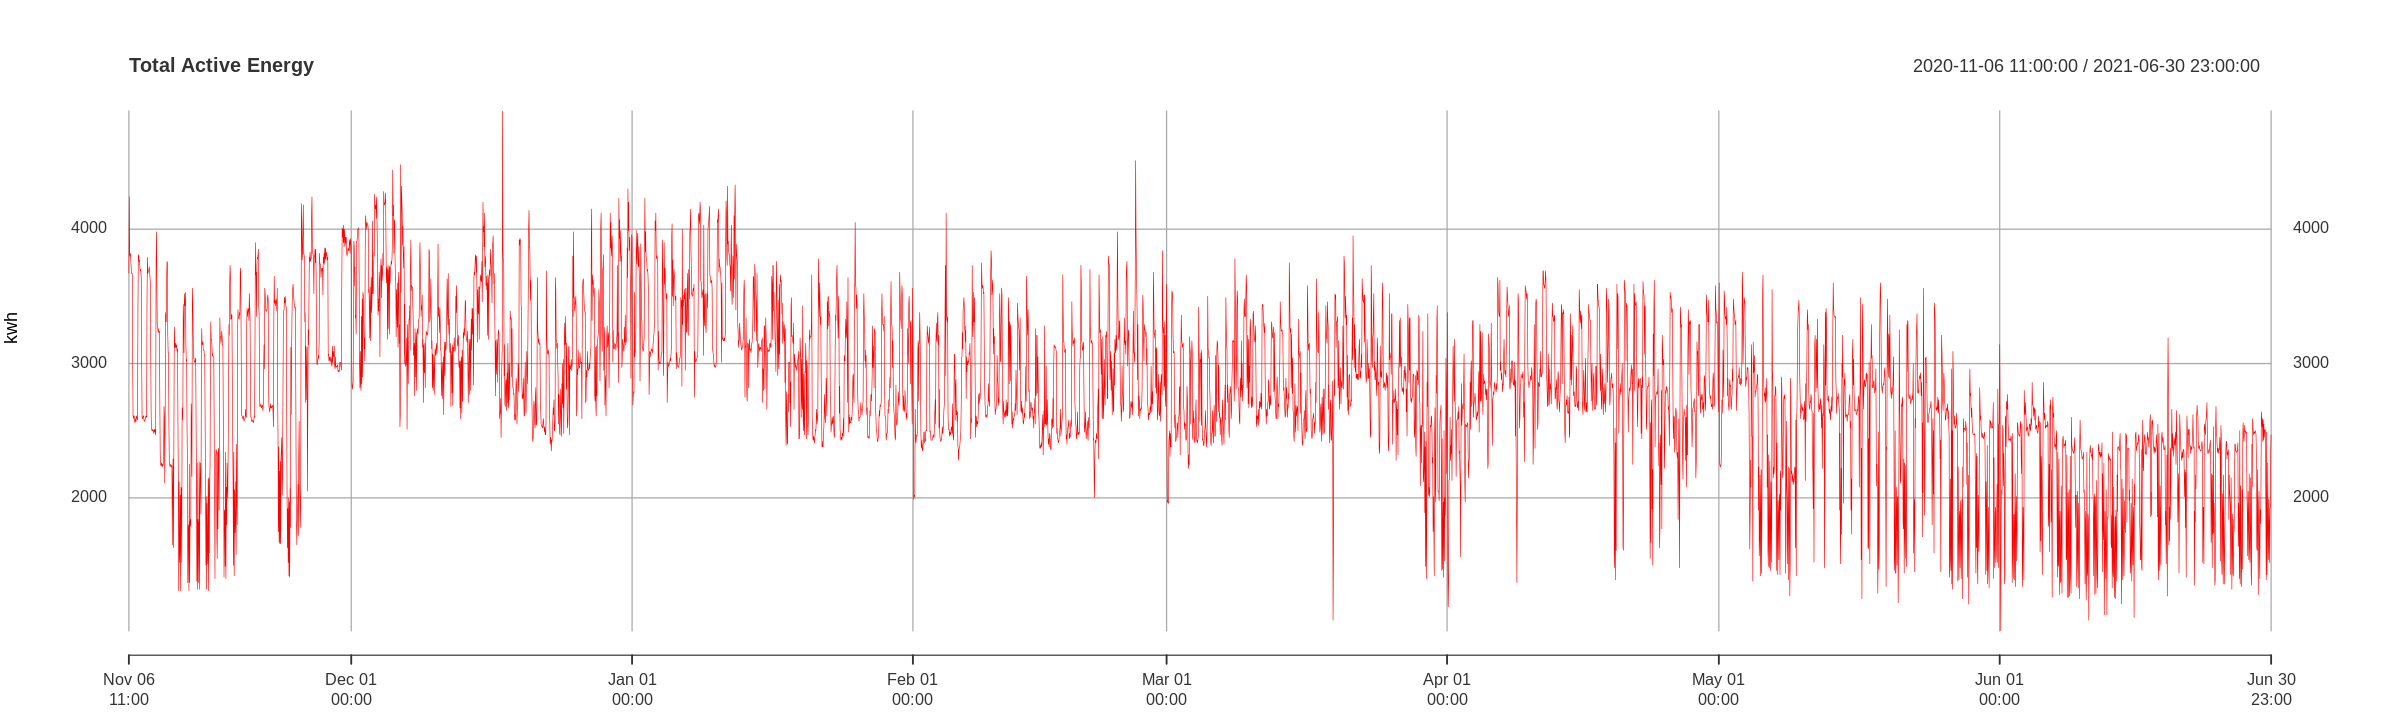

In [166]:
options(repr.plot.width=20, repr.plot.height=6)
plot(j, type="l", col='red', lwd=0.5, main="Total Active Energy", ylab="kwh")

## Outlier handling

2 methods are used to detect outliers (forecast package):
1. tsclean which implements loess decomposition of time series to identify and replace outliers
2. tsoutliers function which implements the Chen and Liu method
Results are exactly the same for both. No outliers are detected at all.

In [167]:
setdiff(tsclean(j)$Diff.Load.Activa.Total..60.minuto., j$Diff.Load.Activa.Total..60.minuto.)

numeric(0)

In [168]:
tsoutliers(j)

$index
integer(0)

$replacements
     Diff.Load.Activa.Total..60.minuto.


## Transforms

In [169]:
lj=log(j) # compute the logartithm of the ts
dlj=diff(lj)

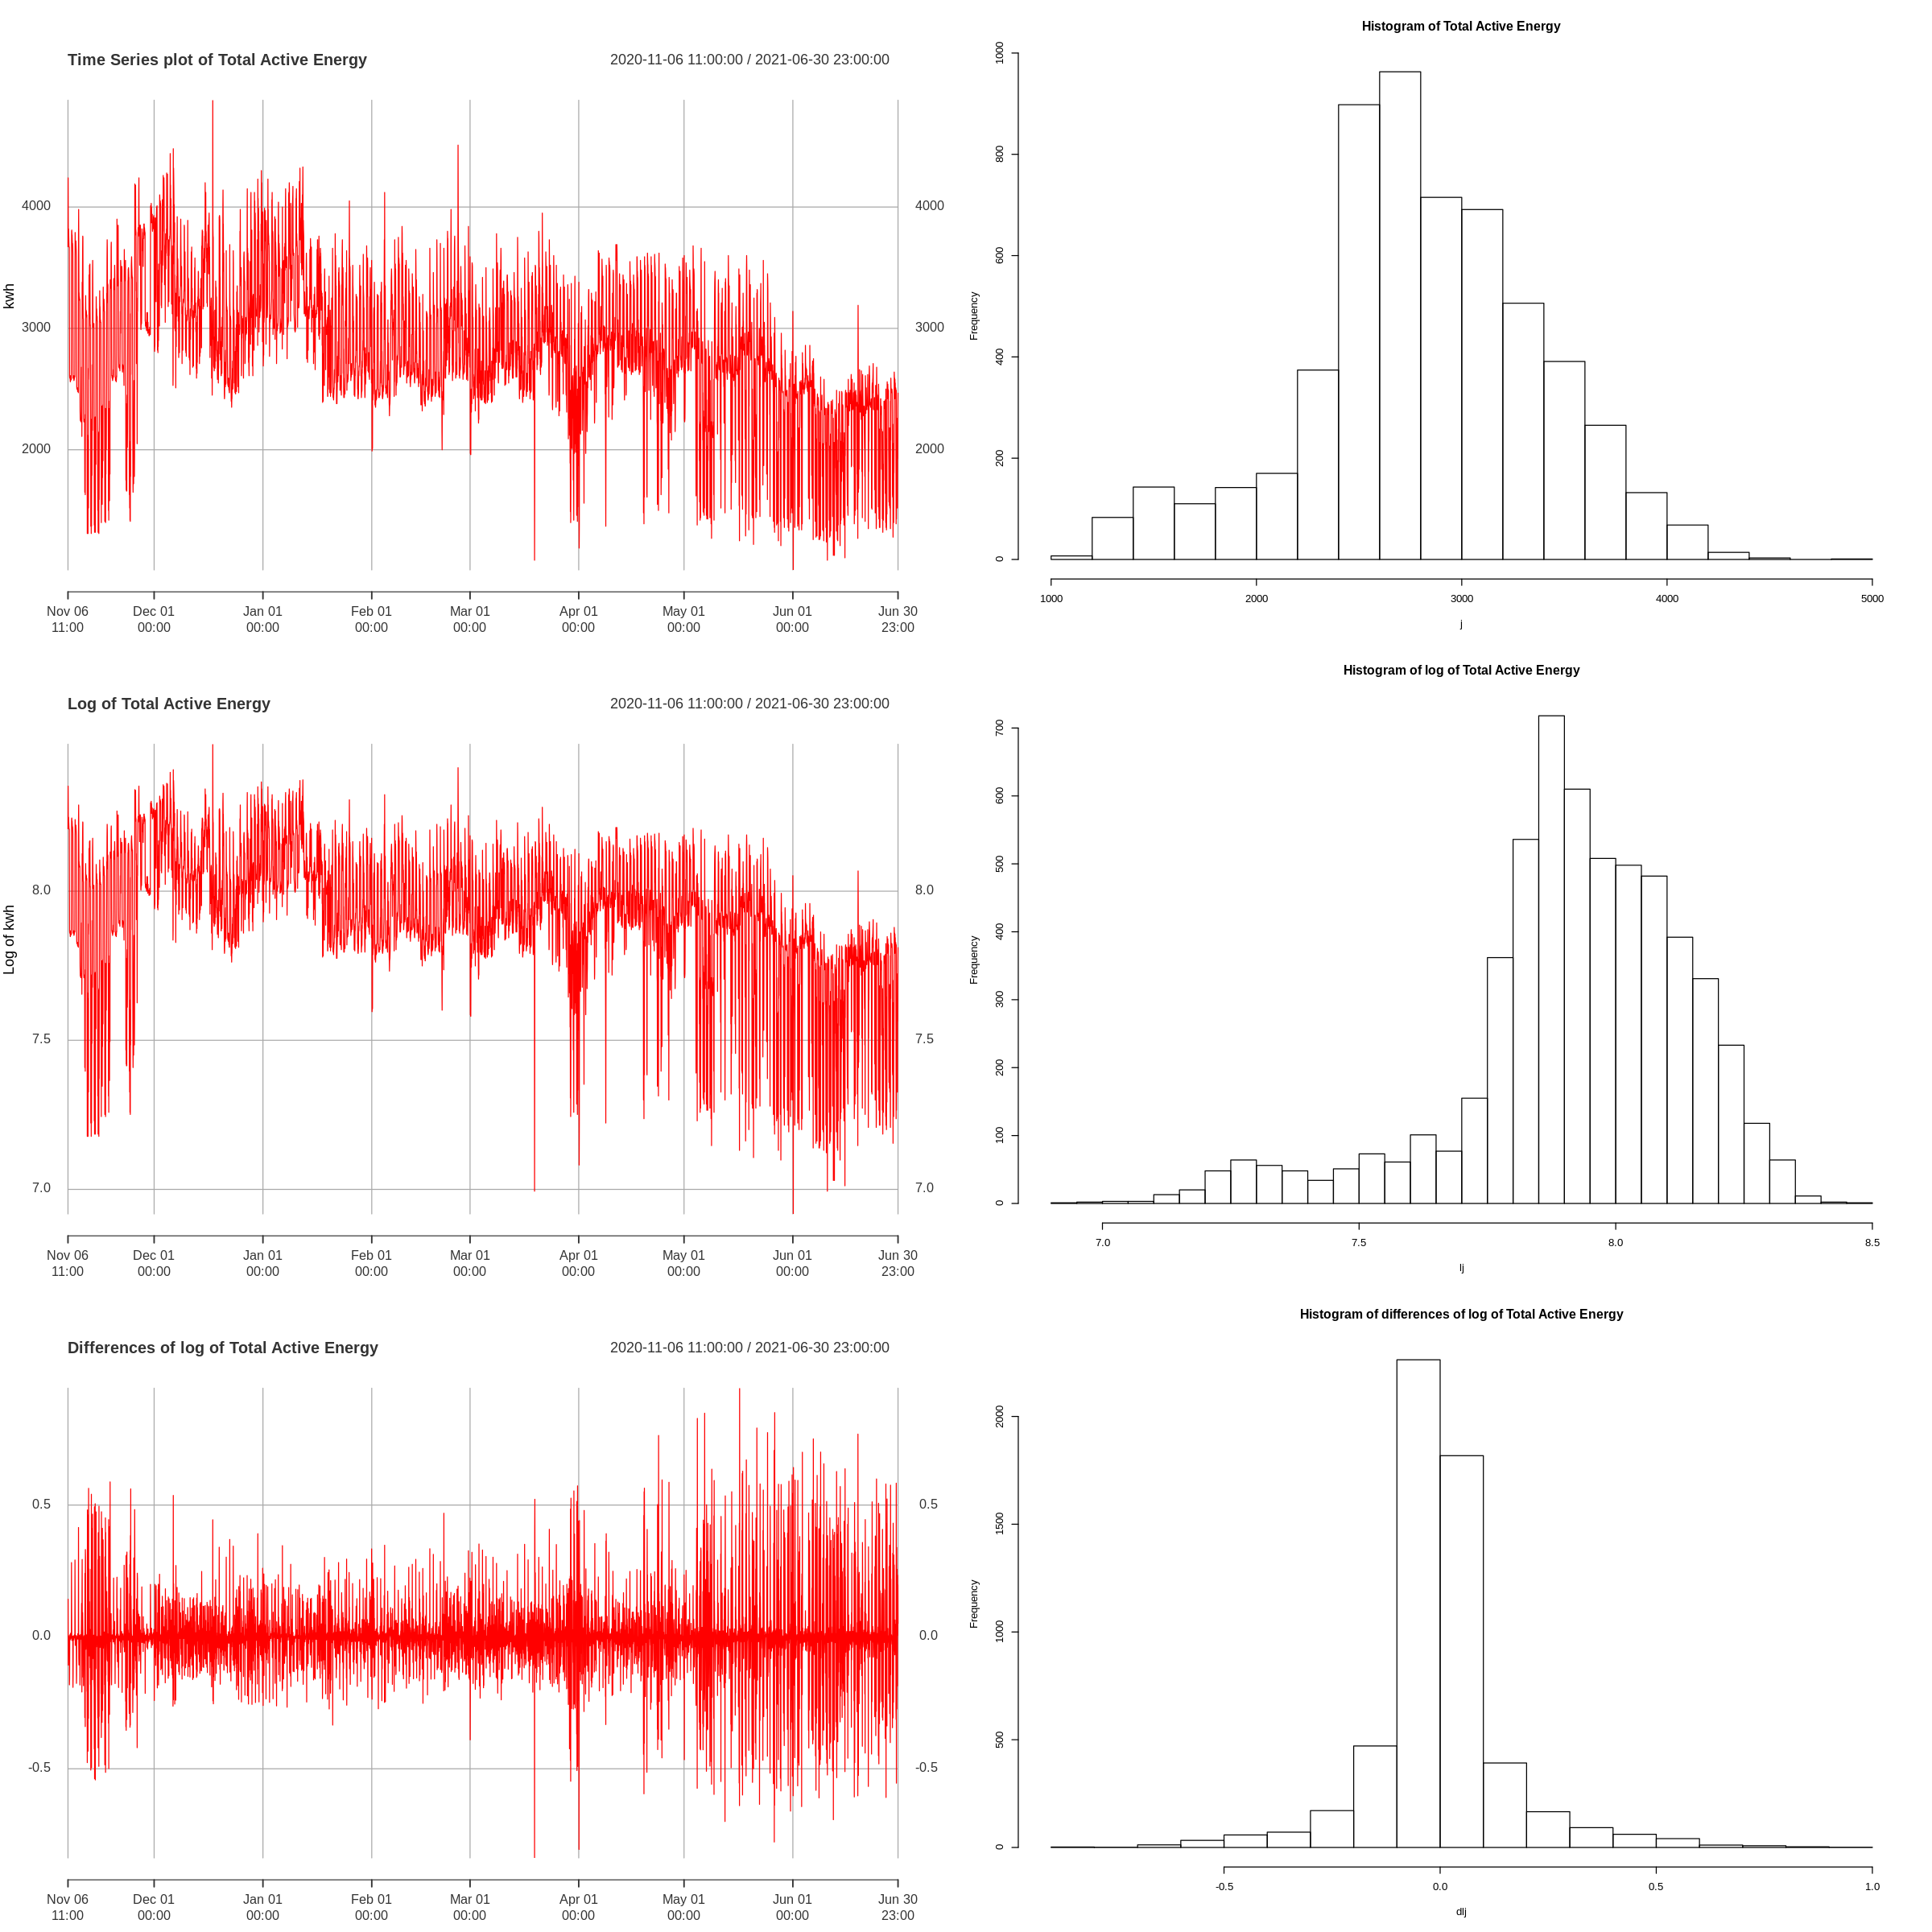

In [170]:
options(repr.plot.width=20, repr.plot.height=20)
par(mfrow=c(3,2)) # set up the graphics
plot(j,type="l", col='red', lwd=1,main="Time Series plot of Total Active Energy", ylab="kwh")
hist(j, nclass=25, main="Histogram of Total Active Energy")
plot(lj,type="l", col='red', lwd=1,main="Log of Total Active Energy", ylab="Log of kwh")
hist(lj, nclass=25, main="Histogram of log of Total Active Energy")
plot(dlj,type="l", col='red', lwd=1,main="Differences of log of Total Active Energy")
hist(dlj, nclass=25, main="Histogram of differences of log of Total Active Energy")

It is observed that following the transformations the time series seems much closer to stationary, excluding the heteroskedasticity that it continues to demonstrate. Additionally it comes very close to a normal distribution.

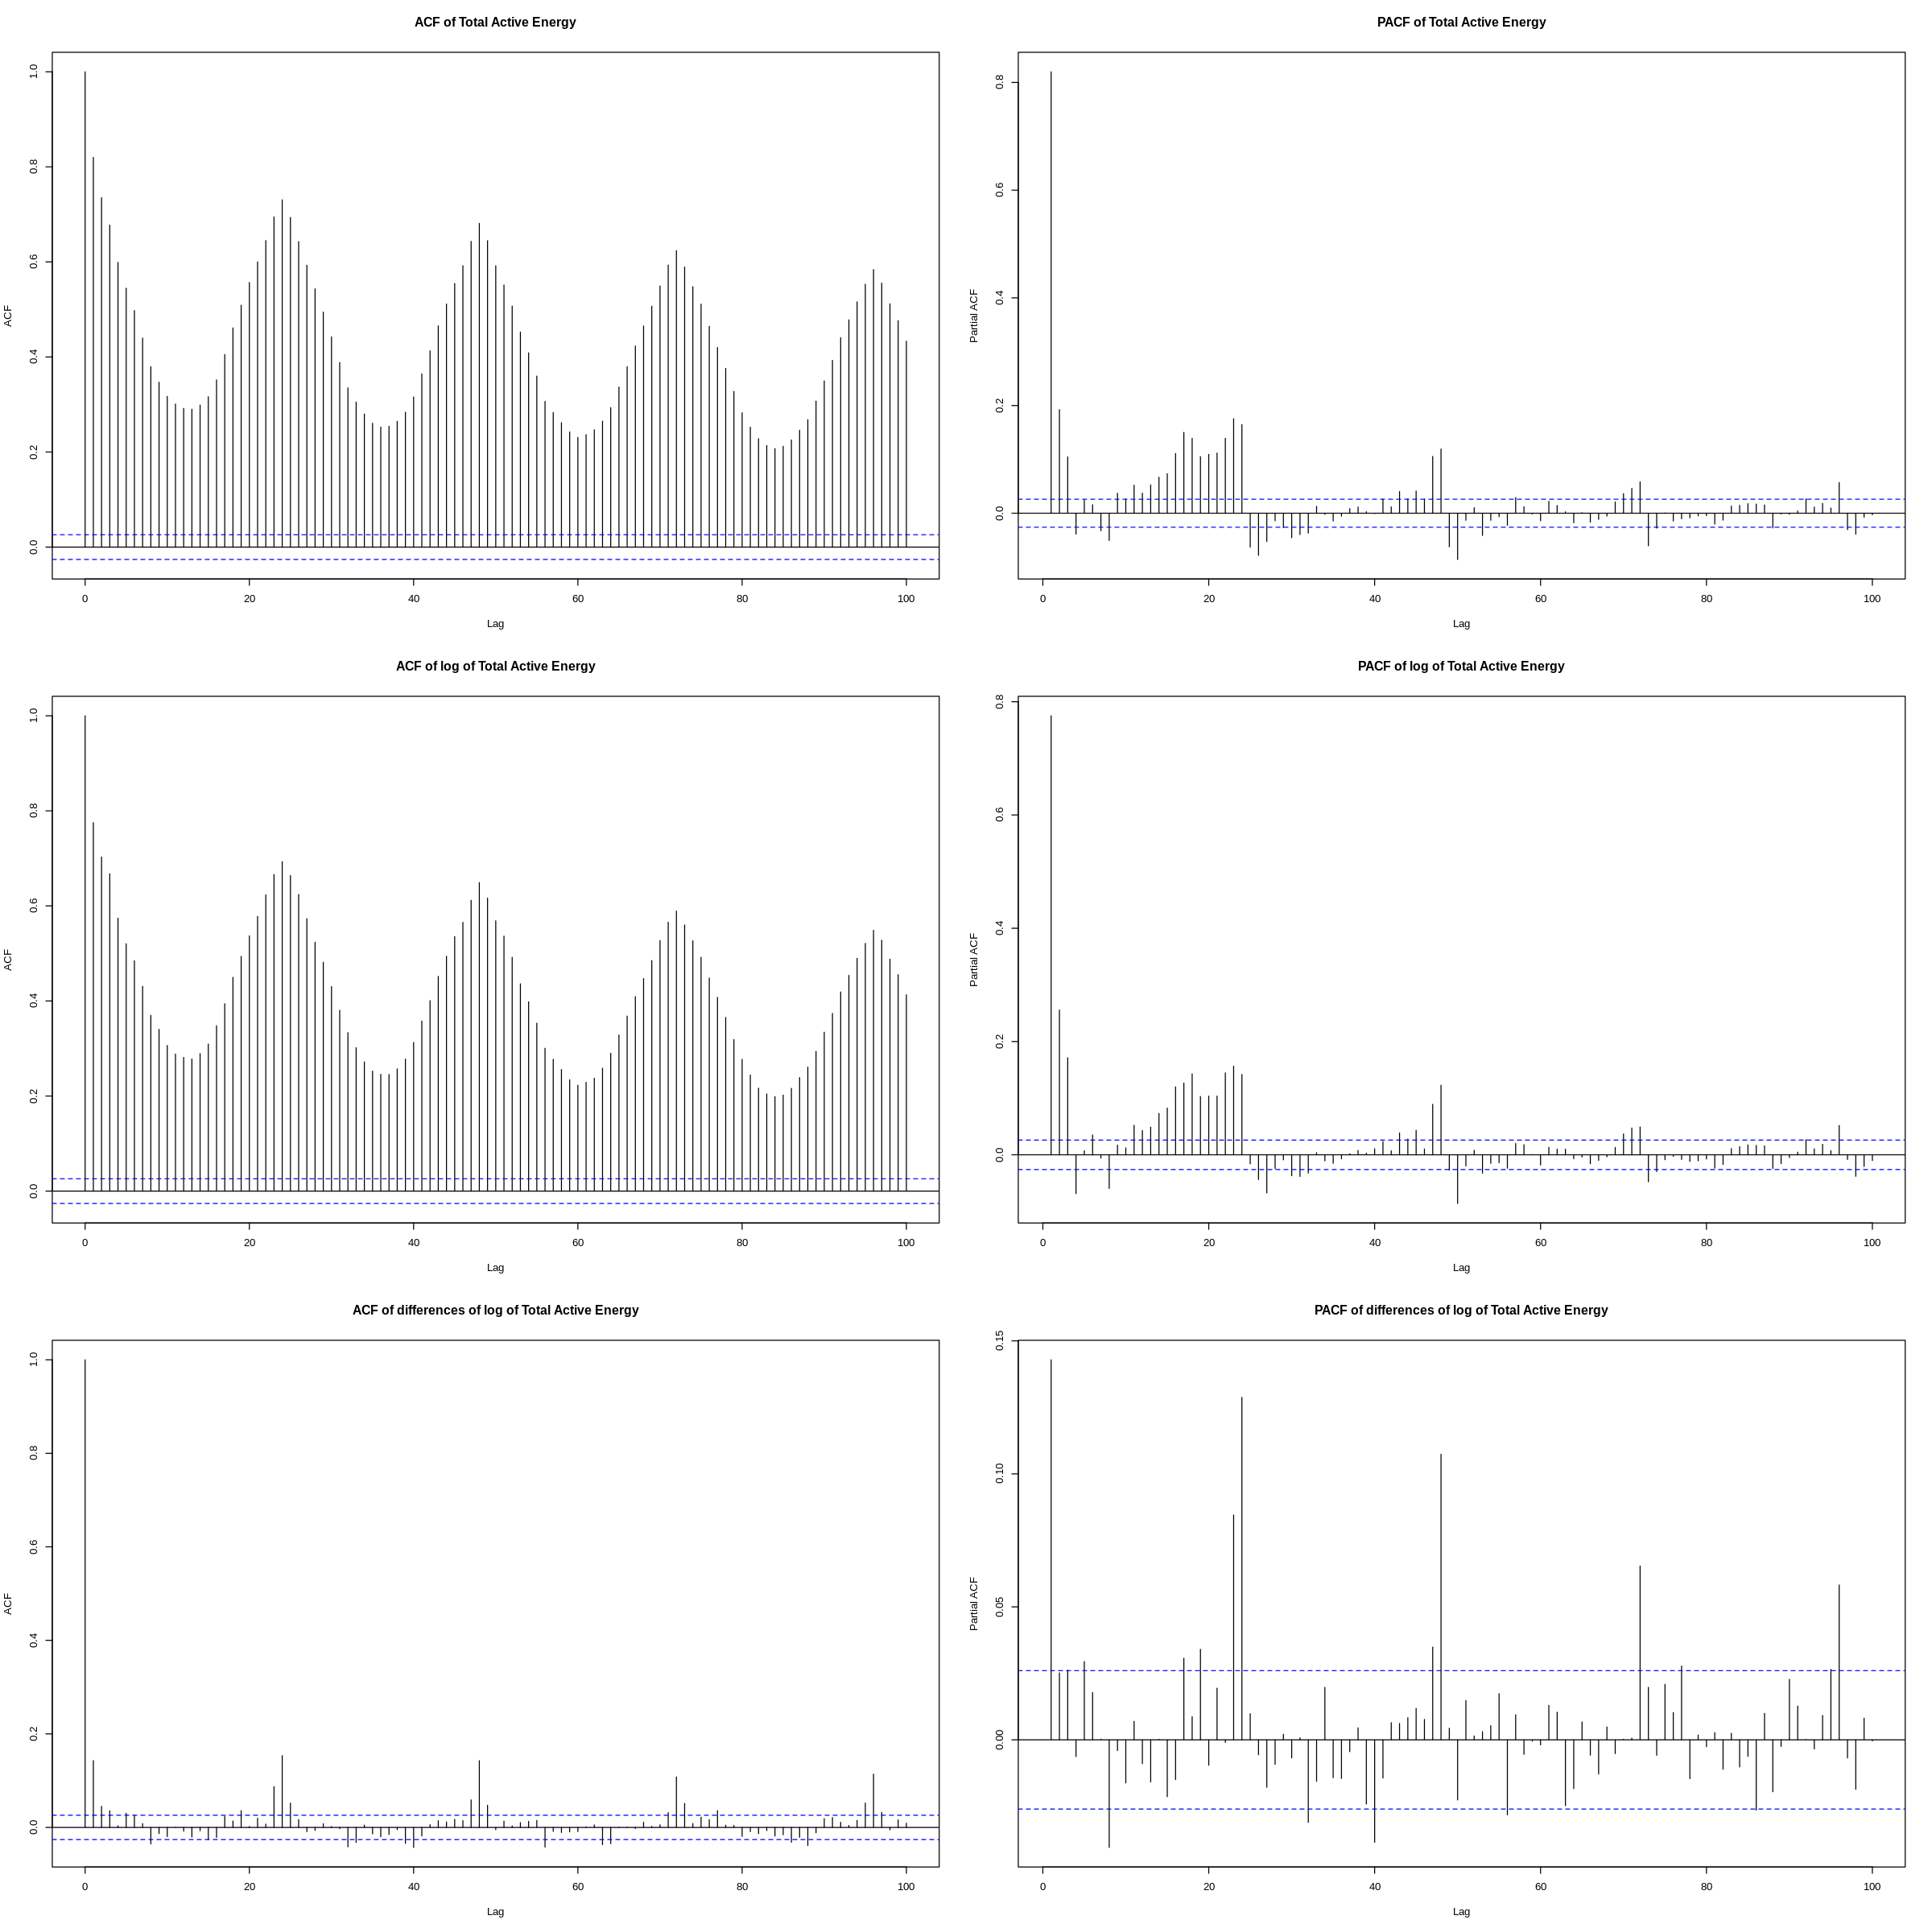

In [171]:
par(mfrow=c(3,2)) # set up the graphics
acf(ts(tsclean(j), freq=1), 100, main="ACF of Total Active Energy") # autocorrelation function plot
pacf(ts(tsclean(j), freq=1), 100, main="PACF of Total Active Energy") # partial autocorrelation function
acf(ts(tsclean(lj), freq=1), 100, main="ACF of log of Total Active Energy")
pacf(ts(tsclean(lj), freq=1), 100, main="PACF of log of Total Active Energy")
acf(ts(tsclean(dlj), freq=1), 100, main="ACF of differences of log of Total Active Energy", na.action = na.pass)
pacf(ts(tsclean(dlj), freq=1), 100, main="PACF of differences of log of Total Active Energy", na.action = na.pass)

## Decomposition
The time series obviously requires decomposition

In [175]:
# set up stl function
fit <- stl(j, s.window="periodic")
autoplot(fit, ts.colour = 'blue')

ERROR: Error in stl(j, s.window = "periodic"): series is not periodic or has less than two periods


In [154]:
jcomp <- decompose(j)

ERROR: Error in decompose(j): time series has no or less than 2 periods


## Unit root testing 

### Drift

#### Original time series

In [142]:
m=ar(tsclean(j))
m
m$order
m1=ur.df(tsclean(j),type="drift",lags=m$order-1)
m1
summary(m1)


Call:
ar(x = tsclean(j))

Coefficients:
      1        2        3        4        5        6        7        8  
 0.4772   0.0979   0.1170  -0.0525   0.0190   0.0486   0.0284  -0.0387  
      9       10       11       12       13       14       15       16  
 0.0309  -0.0059   0.0152  -0.0079  -0.0074  -0.0051  -0.0285  -0.0116  
     17       18       19       20       21       22       23       24  
 0.0232   0.0421   0.0218   0.0271   0.0013   0.0325   0.1025   0.2077  
     25       26       27       28       29       30       31       32  
-0.0153  -0.0477  -0.0390   0.0061   0.0033  -0.0227  -0.0218  -0.0365  

Order selected 32  sigma^2 estimated as  84054

[1] 32


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -3.8066 7.3039 



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1514.05  -128.24     6.49   133.92  1746.06 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  99.346845  26.723160   3.718 0.000203 ***
z.lag.1      -0.035737   0.009388  -3.807 0.000142 ***
z.diff.lag1  -0.494674   0.015912 -31.088  < 2e-16 ***
z.diff.lag2  -0.398306   0.017222 -23.127  < 2e-16 ***
z.diff.lag3  -0.282746   0.018008 -15.701  < 2e-16 ***
z.diff.lag4  -0.335866   0.018385 -18.268  < 2e-16 ***
z.diff.lag5  -0.317238   0.018909 -16.777  < 2e-16 ***
z.diff.lag6  -0.268546   0.019343 -13.883  < 2e-16 ***
z.diff.lag7  -0.239348   0.019576 -12.227  < 2e-16 ***
z.diff.lag8  -0.276740   0.019705 -14.044  < 2e-16 ***
z.diff.lag9  -0.245536   0.019999 -12.278  < 2e-

#### Log time series

In [12]:
m=ar(lj)
m
m$order
m1=ur.df(lj,type="drift",lags=m$order-1)
m1
summary(m1)


Call:
ar(x = lj)

Coefficients:
      1        2        3        4        5        6        7        8  
-0.0491   0.3111   0.3961   0.0627  -0.0985   0.1163  -0.0417   0.0127  
      9       10       11       12       13       14       15       16  
 0.0332   0.0232   0.0073   0.0005   0.0038   0.0217   0.0054  -0.0306  
     17       18       19       20       21       22       23       24  
 0.0014  -0.0051  -0.0091  -0.0285   0.0045   0.0136  -0.0010  -0.0157  
     25       26       27       28       29       30       31       32  
-0.0200  -0.0030   0.0056   0.0007  -0.0225  -0.0177  -0.0051  -0.0017  
     33       34       35       36       37       38       39       40  
 0.0130   0.0193   0.0635   0.0208   0.0033   0.0274   0.0565   0.0637  

Order selected 40  sigma^2 estimated as  0.04075

[1] 40


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -5.4351 14.7948 



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.55851 -0.07889  0.01921  0.10249  1.31110 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.434760   0.080090   5.428 5.80e-08 ***
z.lag.1      -0.060320   0.011098  -5.435 5.59e-08 ***
z.diff.lag1  -0.990750   0.014136 -70.087  < 2e-16 ***
z.diff.lag2  -0.681194   0.016842 -40.445  < 2e-16 ***
z.diff.lag3  -0.285721   0.017912 -15.951  < 2e-16 ***
z.diff.lag4  -0.222952   0.018002 -12.385  < 2e-16 ***
z.diff.lag5  -0.321370   0.017985 -17.869  < 2e-16 ***
z.diff.lag6  -0.204911   0.018015 -11.375  < 2e-16 ***
z.diff.lag7  -0.246484   0.017866 -13.797  < 2e-16 ***
z.diff.lag8  -0.233762   0.017745 -13.173  < 2e-16 ***
z.diff.lag9  -0.200448   0.017614 -11.380  < 2e-

#### Diff log time series
This time series needs to be imputed with tsclean in order to be processed as it has missing values. But why missing values here. The simple logarithm transformation was ok! Is it only the first?

In [13]:
m=ar(tsclean(dlj))
m
m$order
m1=ur.df(tsclean(dlj),type="drift", lags=m$order-1)
m1
summary(m1)


Call:
ar(x = tsclean(dlj))

Coefficients:
      1        2        3        4        5        6        7        8  
-0.4431   0.0854   0.0352  -0.0056  -0.0551   0.0733   0.0296  -0.0231  
      9       10       11       12       13       14       15       16  
-0.0601  -0.0446  -0.0134   0.0252   0.0148   0.0196   0.0197  -0.0340  
     17       18       19       20       21       22       23       24  
-0.0245  -0.0133   0.0090  -0.0127  -0.0032   0.0120   0.0182   0.0022  
     25       26       27       28       29       30       31       32  
-0.0213   0.0023  -0.0090  -0.0059   0.0023   0.0079   0.0033  -0.0252  
     33       34       35       36       37       38       39       40  
-0.0223   0.0077   0.0077   0.0002   0.0256   0.0267   0.0289   0.0413  

Order selected 40  sigma^2 estimated as  0.05064

[1] 40


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -16.0508 128.8146 



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.16675 -0.09774  0.00142  0.10505  1.37138 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.0007826  0.0021157  -0.370 0.711458    
z.lag.1      -1.3188153  0.0821651 -16.051  < 2e-16 ***
z.diff.lag1  -0.1243434  0.0812194  -1.531 0.125808    
z.diff.lag2  -0.0390270  0.0801712  -0.487 0.626412    
z.diff.lag3  -0.0038488  0.0790588  -0.049 0.961173    
z.diff.lag4  -0.0094293  0.0778878  -0.121 0.903643    
z.diff.lag5  -0.0645561  0.0766992  -0.842 0.399986    
z.diff.lag6   0.0087224  0.0754813   0.116 0.908006    
z.diff.lag7   0.0383545  0.0742270   0.517 0.605363    
z.diff.lag8   0.0151143  0.0729919   0.207 0.835961    
z.diff.lag9  -0.0450789  0.0717791  -

The null hypothesis of non-stationarity is rejected for all cases with respect to drift.

### Trend

#### Original time series

In [14]:
m=ar(j)
m
m$order
m1=ur.df(j,type="trend",lags=m$order-1)
m1
summary(m1)


Call:
ar(x = j)

Coefficients:
      1        2        3        4        5        6        7        8  
-0.0025   0.4379   0.2976   0.0208  -0.1061   0.1131  -0.0136  -0.0020  
      9       10       11       12       13       14       15       16  
 0.0346   0.0169  -0.0009   0.0160   0.0088   0.0248  -0.0129  -0.0692  
     17       18       19       20       21       22       23       24  
-0.0102   0.0114   0.0168  -0.0188   0.0021   0.0141  -0.0002  -0.0138  
     25       26       27       28       29       30       31       32  
-0.0150   0.0040   0.0025  -0.0078  -0.0146  -0.0100  -0.0111  -0.0332  
     33       34       35       36       37       38       39       40  
 0.0002   0.0482   0.0684   0.0113  -0.0079   0.0253   0.0569   0.0657  

Order selected 40  sigma^2 estimated as  46371

[1] 40


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -7.272 17.6506 26.4503 



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1211.00  -114.23    10.22   125.46  1052.71 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.589e+02  2.221e+01   7.151 9.16e-13 ***
z.lag.1      -9.600e-02  1.320e-02  -7.272 3.78e-13 ***
tt           -4.213e-03  8.374e-04  -5.031 4.95e-07 ***
z.diff.lag1  -9.119e-01  1.563e-02 -58.352  < 2e-16 ***
z.diff.lag2  -4.785e-01  1.771e-02 -27.021  < 2e-16 ***
z.diff.lag3  -1.827e-01  1.813e-02 -10.074  < 2e-16 ***
z.diff.lag4  -1.626e-01  1.809e-02  -8.989  < 2e-16 ***
z.diff.lag5  -2.695e-01  1.801e-02 -14.969  < 2e-16 ***
z.diff.lag6  -1.577e-01  1.795e-02  -8.790  < 2e-16 ***
z.diff.lag7  -1.720e-01  1.769e-02  -9.725  < 2e-16 ***
z.diff.lag8  -1.750e-01  1.744e-

#### Log time series

In [15]:
m=ar(lj)
m
m$order
m1=ur.df(lj,type="trend",lags=m$order-1)
m1
summary(m1)


Call:
ar(x = lj)

Coefficients:
      1        2        3        4        5        6        7        8  
-0.0491   0.3111   0.3961   0.0627  -0.0985   0.1163  -0.0417   0.0127  
      9       10       11       12       13       14       15       16  
 0.0332   0.0232   0.0073   0.0005   0.0038   0.0217   0.0054  -0.0306  
     17       18       19       20       21       22       23       24  
 0.0014  -0.0051  -0.0091  -0.0285   0.0045   0.0136  -0.0010  -0.0157  
     25       26       27       28       29       30       31       32  
-0.0200  -0.0030   0.0056   0.0007  -0.0225  -0.0177  -0.0051  -0.0017  
     33       34       35       36       37       38       39       40  
 0.0130   0.0193   0.0635   0.0208   0.0033   0.0274   0.0565   0.0637  

Order selected 40  sigma^2 estimated as  0.04075

[1] 40


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -7.5396 18.9739 28.4363 



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.54599 -0.07998  0.01805  0.10201  1.30731 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   8.417e-01  1.117e-01   7.536 5.20e-14 ***
z.lag.1      -1.135e-01  1.505e-02  -7.540 5.07e-14 ***
tt           -4.093e-06  7.840e-07  -5.221 1.81e-07 ***
z.diff.lag1  -9.401e-01  1.713e-02 -54.896  < 2e-16 ***
z.diff.lag2  -6.334e-01  1.915e-02 -33.073  < 2e-16 ***
z.diff.lag3  -2.401e-01  1.991e-02 -12.055  < 2e-16 ***
z.diff.lag4  -1.785e-01  1.990e-02  -8.971  < 2e-16 ***
z.diff.lag5  -2.780e-01  1.979e-02 -14.045  < 2e-16 ***
z.diff.lag6  -1.630e-01  1.970e-02  -8.272  < 2e-16 ***
z.diff.lag7  -2.058e-01  1.947e-02 -10.569  < 2e-16 ***
z.diff.lag8  -1.945e-01  1.926e-

#### Diff log time series
This time series needs to be imputed with tsclean in order to be processed as it has missing values. But why missing values here. The simple logarithm transformation was ok! Is it only the first?

In [22]:
m=ar(tsclean(dlj))
m
m$order
m1=ur.df(tsclean(dlj),type="trend", lags=m$order-1)
m1
summary(m1)


Call:
ar(x = tsclean(dlj))

Coefficients:
      1        2        3        4        5        6        7        8  
-0.4431   0.0854   0.0352  -0.0056  -0.0551   0.0733   0.0296  -0.0231  
      9       10       11       12       13       14       15       16  
-0.0601  -0.0446  -0.0134   0.0252   0.0148   0.0196   0.0197  -0.0340  
     17       18       19       20       21       22       23       24  
-0.0245  -0.0133   0.0090  -0.0127  -0.0032   0.0120   0.0182   0.0022  
     25       26       27       28       29       30       31       32  
-0.0213   0.0023  -0.0090  -0.0059   0.0023   0.0079   0.0033  -0.0252  
     33       34       35       36       37       38       39       40  
-0.0223   0.0077   0.0077   0.0002   0.0256   0.0267   0.0289   0.0413  

Order selected 40  sigma^2 estimated as  0.05064

[1] 40


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -16.0822 86.2131 129.3189 



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.16323 -0.09757  0.00066  0.10579  1.37431 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.928e-03  4.256e-03   0.688 0.491471    
z.lag.1      -1.324e+00  8.233e-02 -16.082  < 2e-16 ***
tt           -6.495e-07  6.464e-07  -1.005 0.314999    
z.diff.lag1  -1.192e-01  8.138e-02  -1.464 0.143109    
z.diff.lag2  -3.400e-02  8.033e-02  -0.423 0.672141    
z.diff.lag3   1.048e-03  7.921e-02   0.013 0.989447    
z.diff.lag4  -4.668e-03  7.803e-02  -0.060 0.952294    
z.diff.lag5  -5.993e-02  7.684e-02  -0.780 0.435446    
z.diff.lag6   1.321e-02  7.561e-02   0.175 0.861304    
z.diff.lag7   4.271e-02  7.435e-02   0.574 0.565690    
z.diff.lag8   1.934e-02  7.311e-

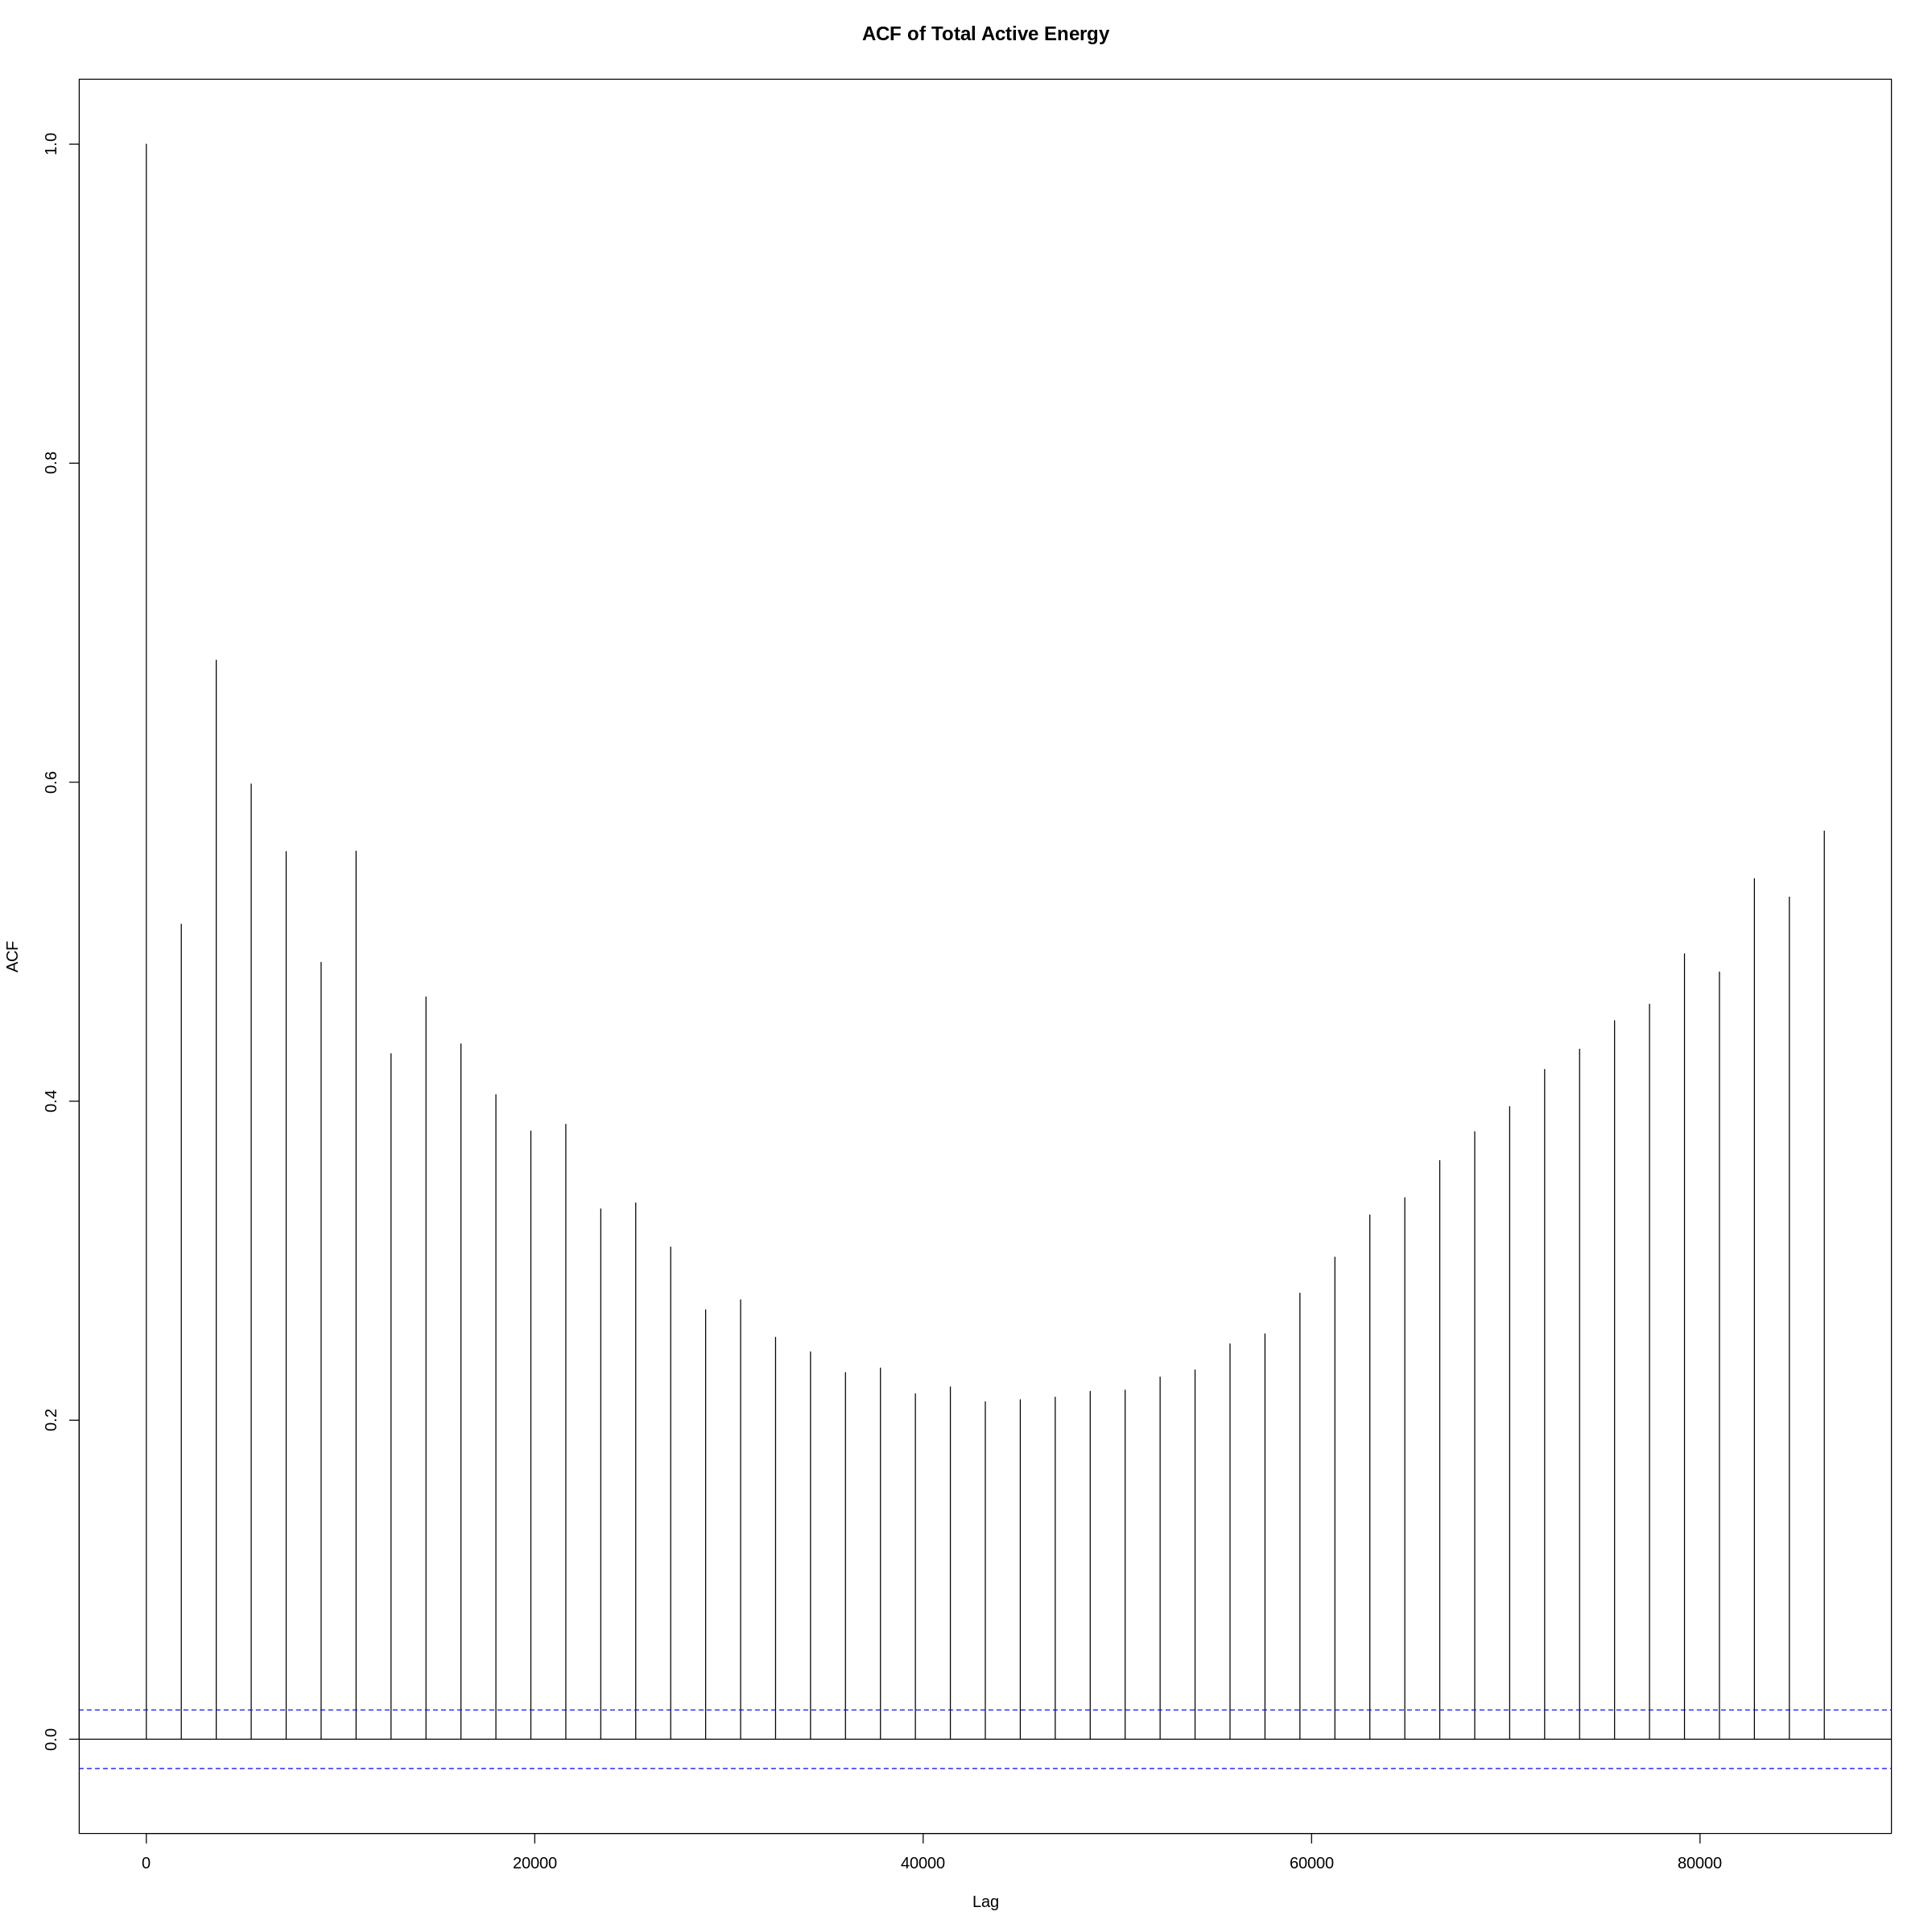

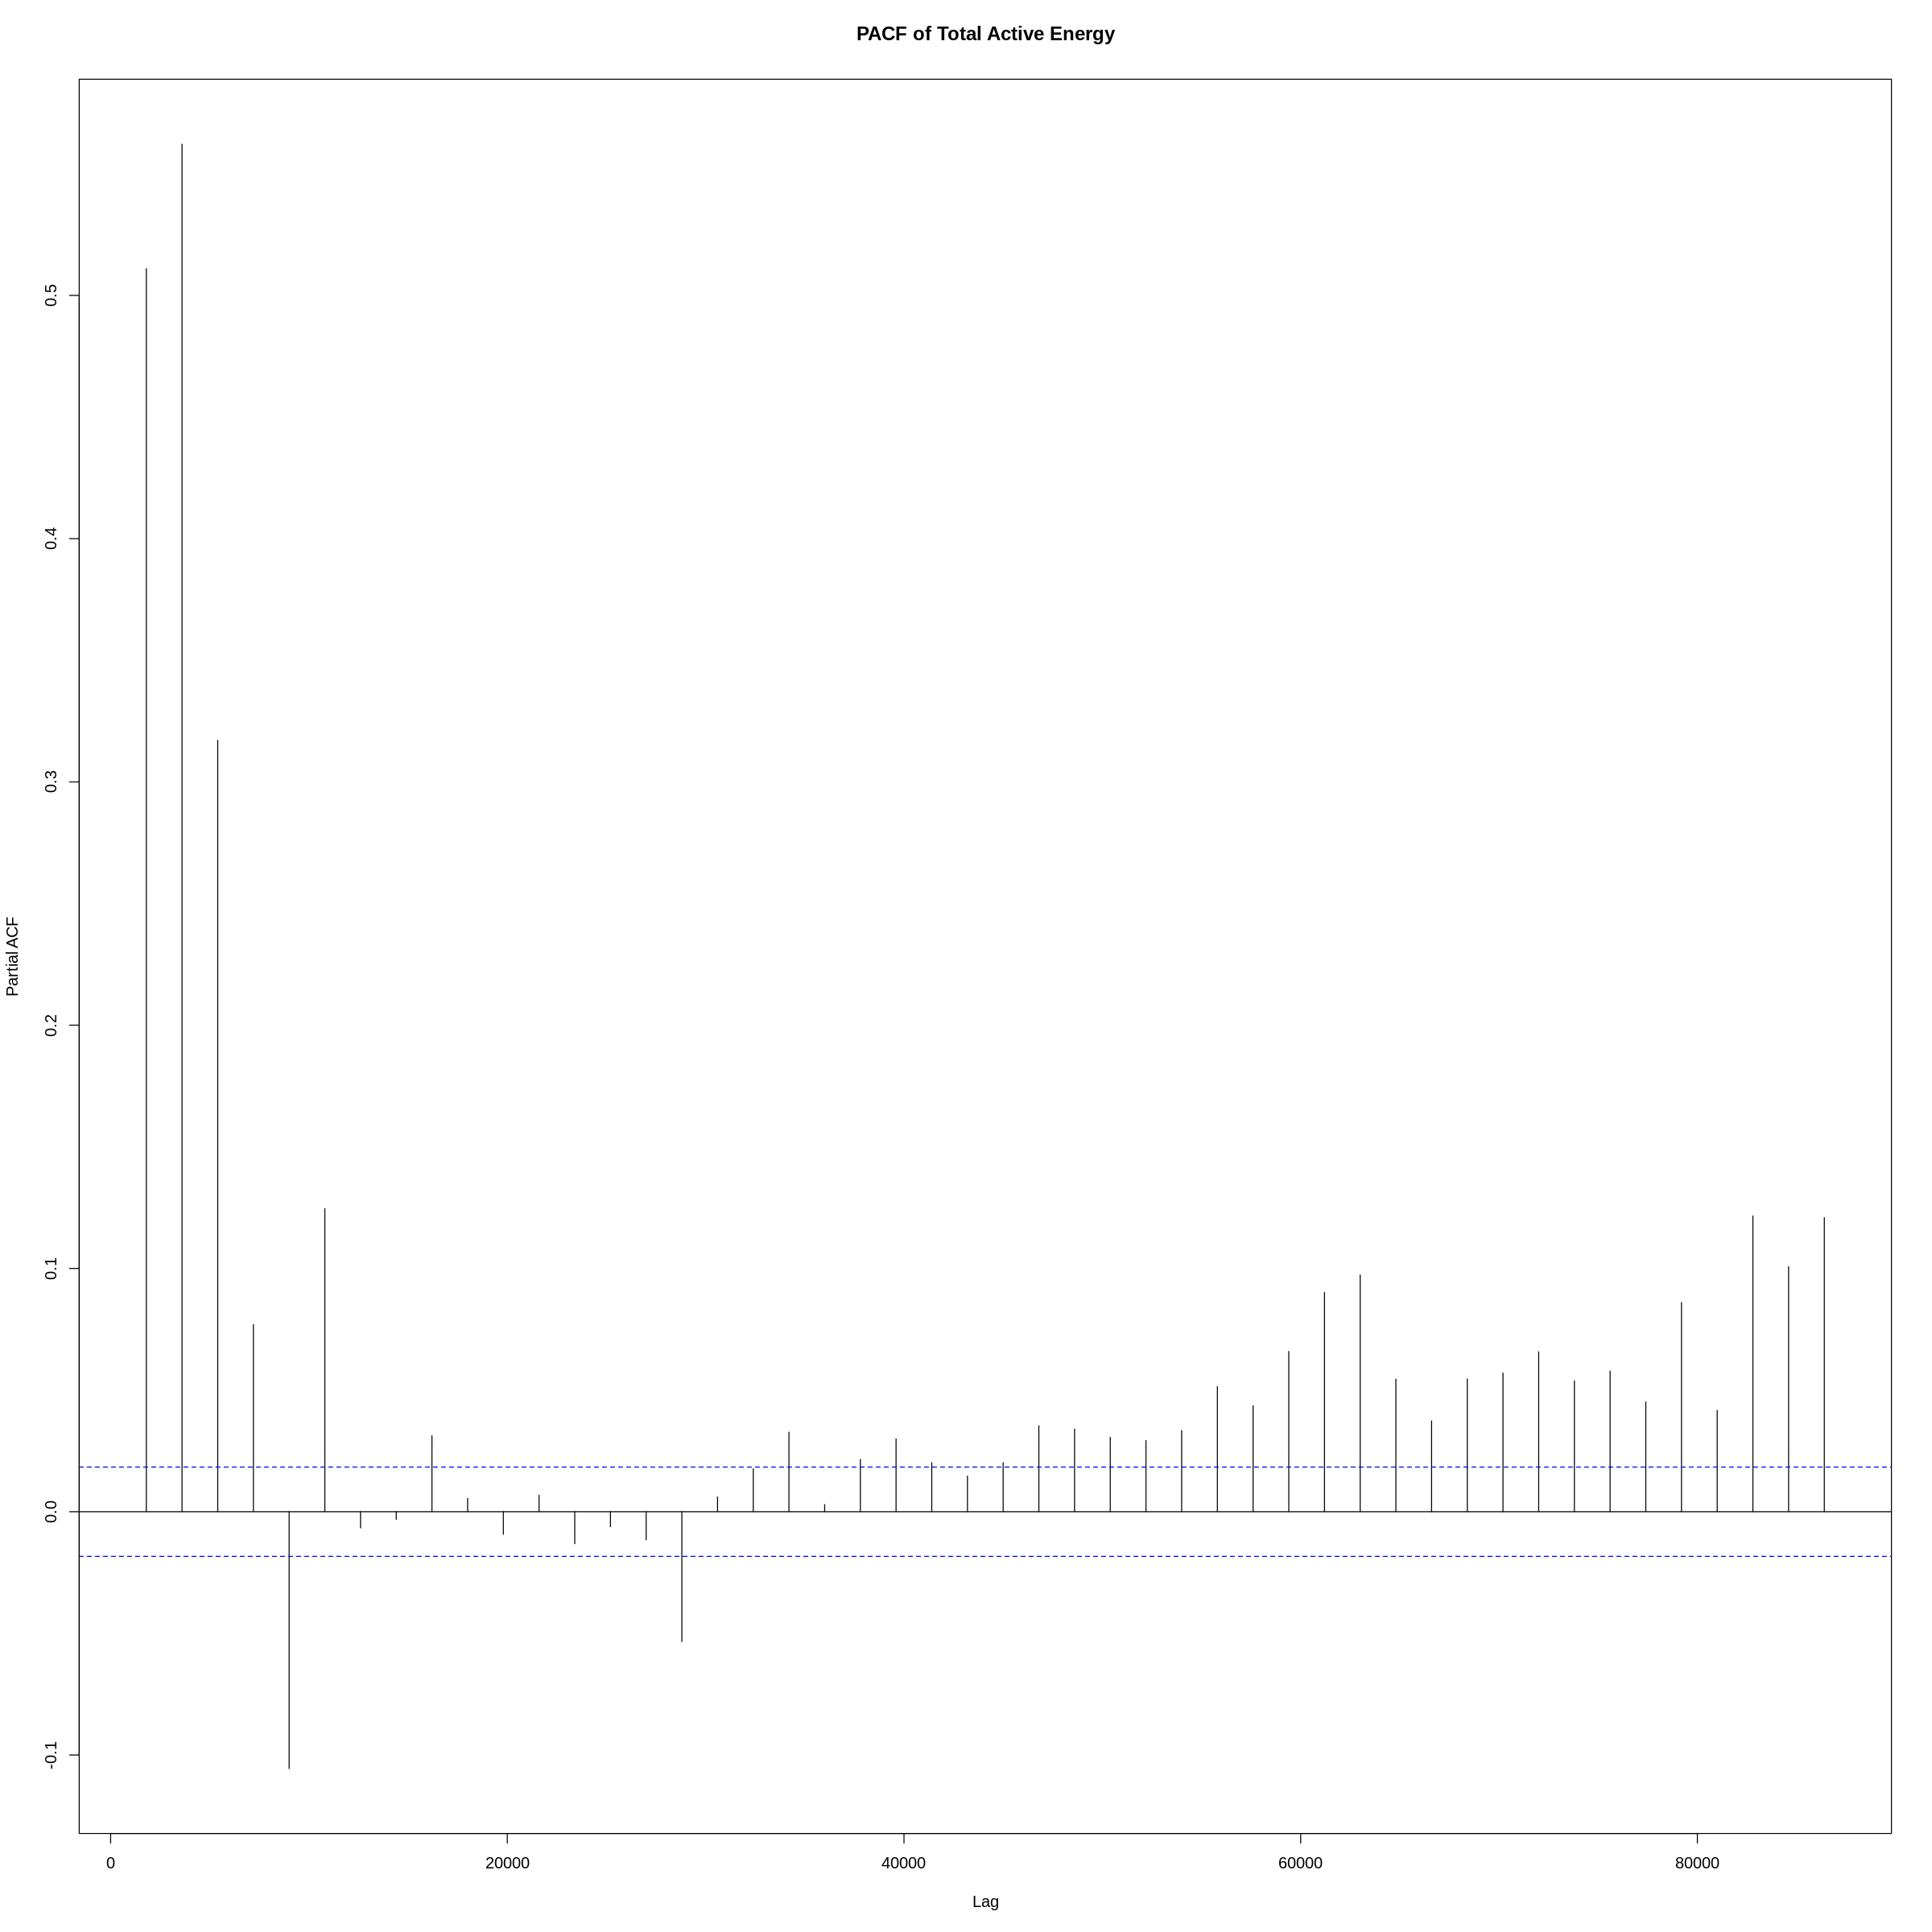

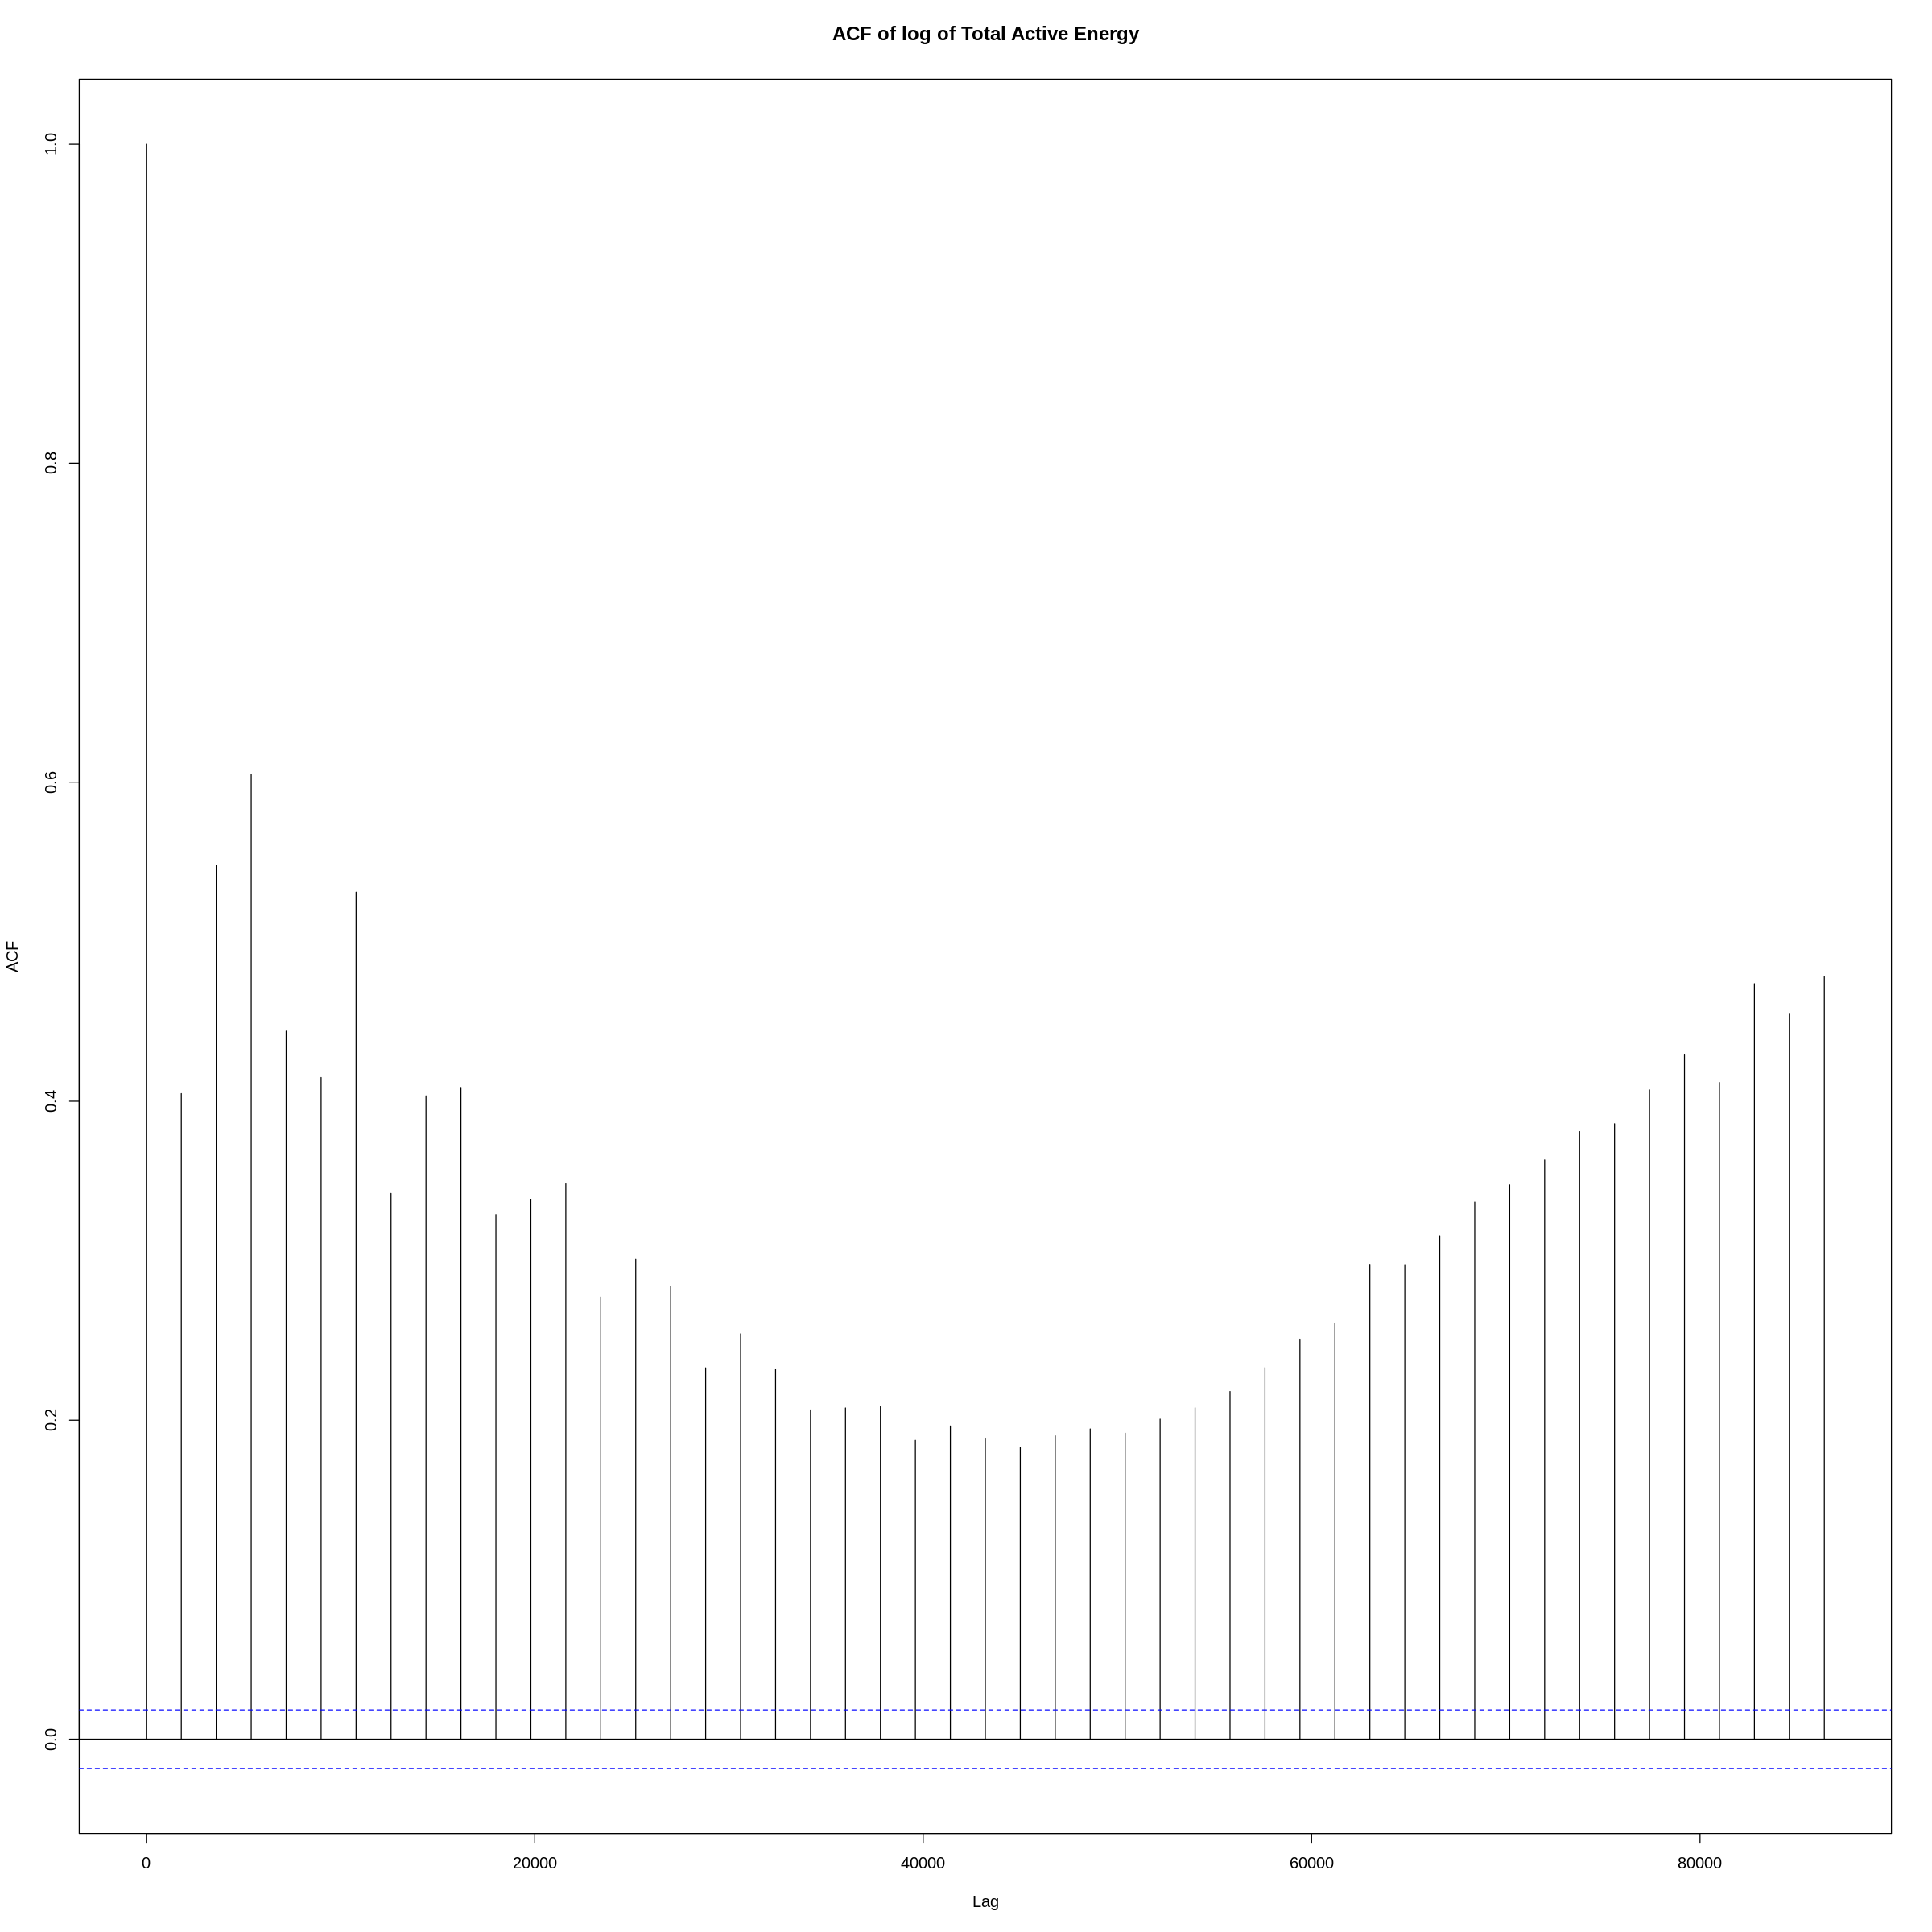

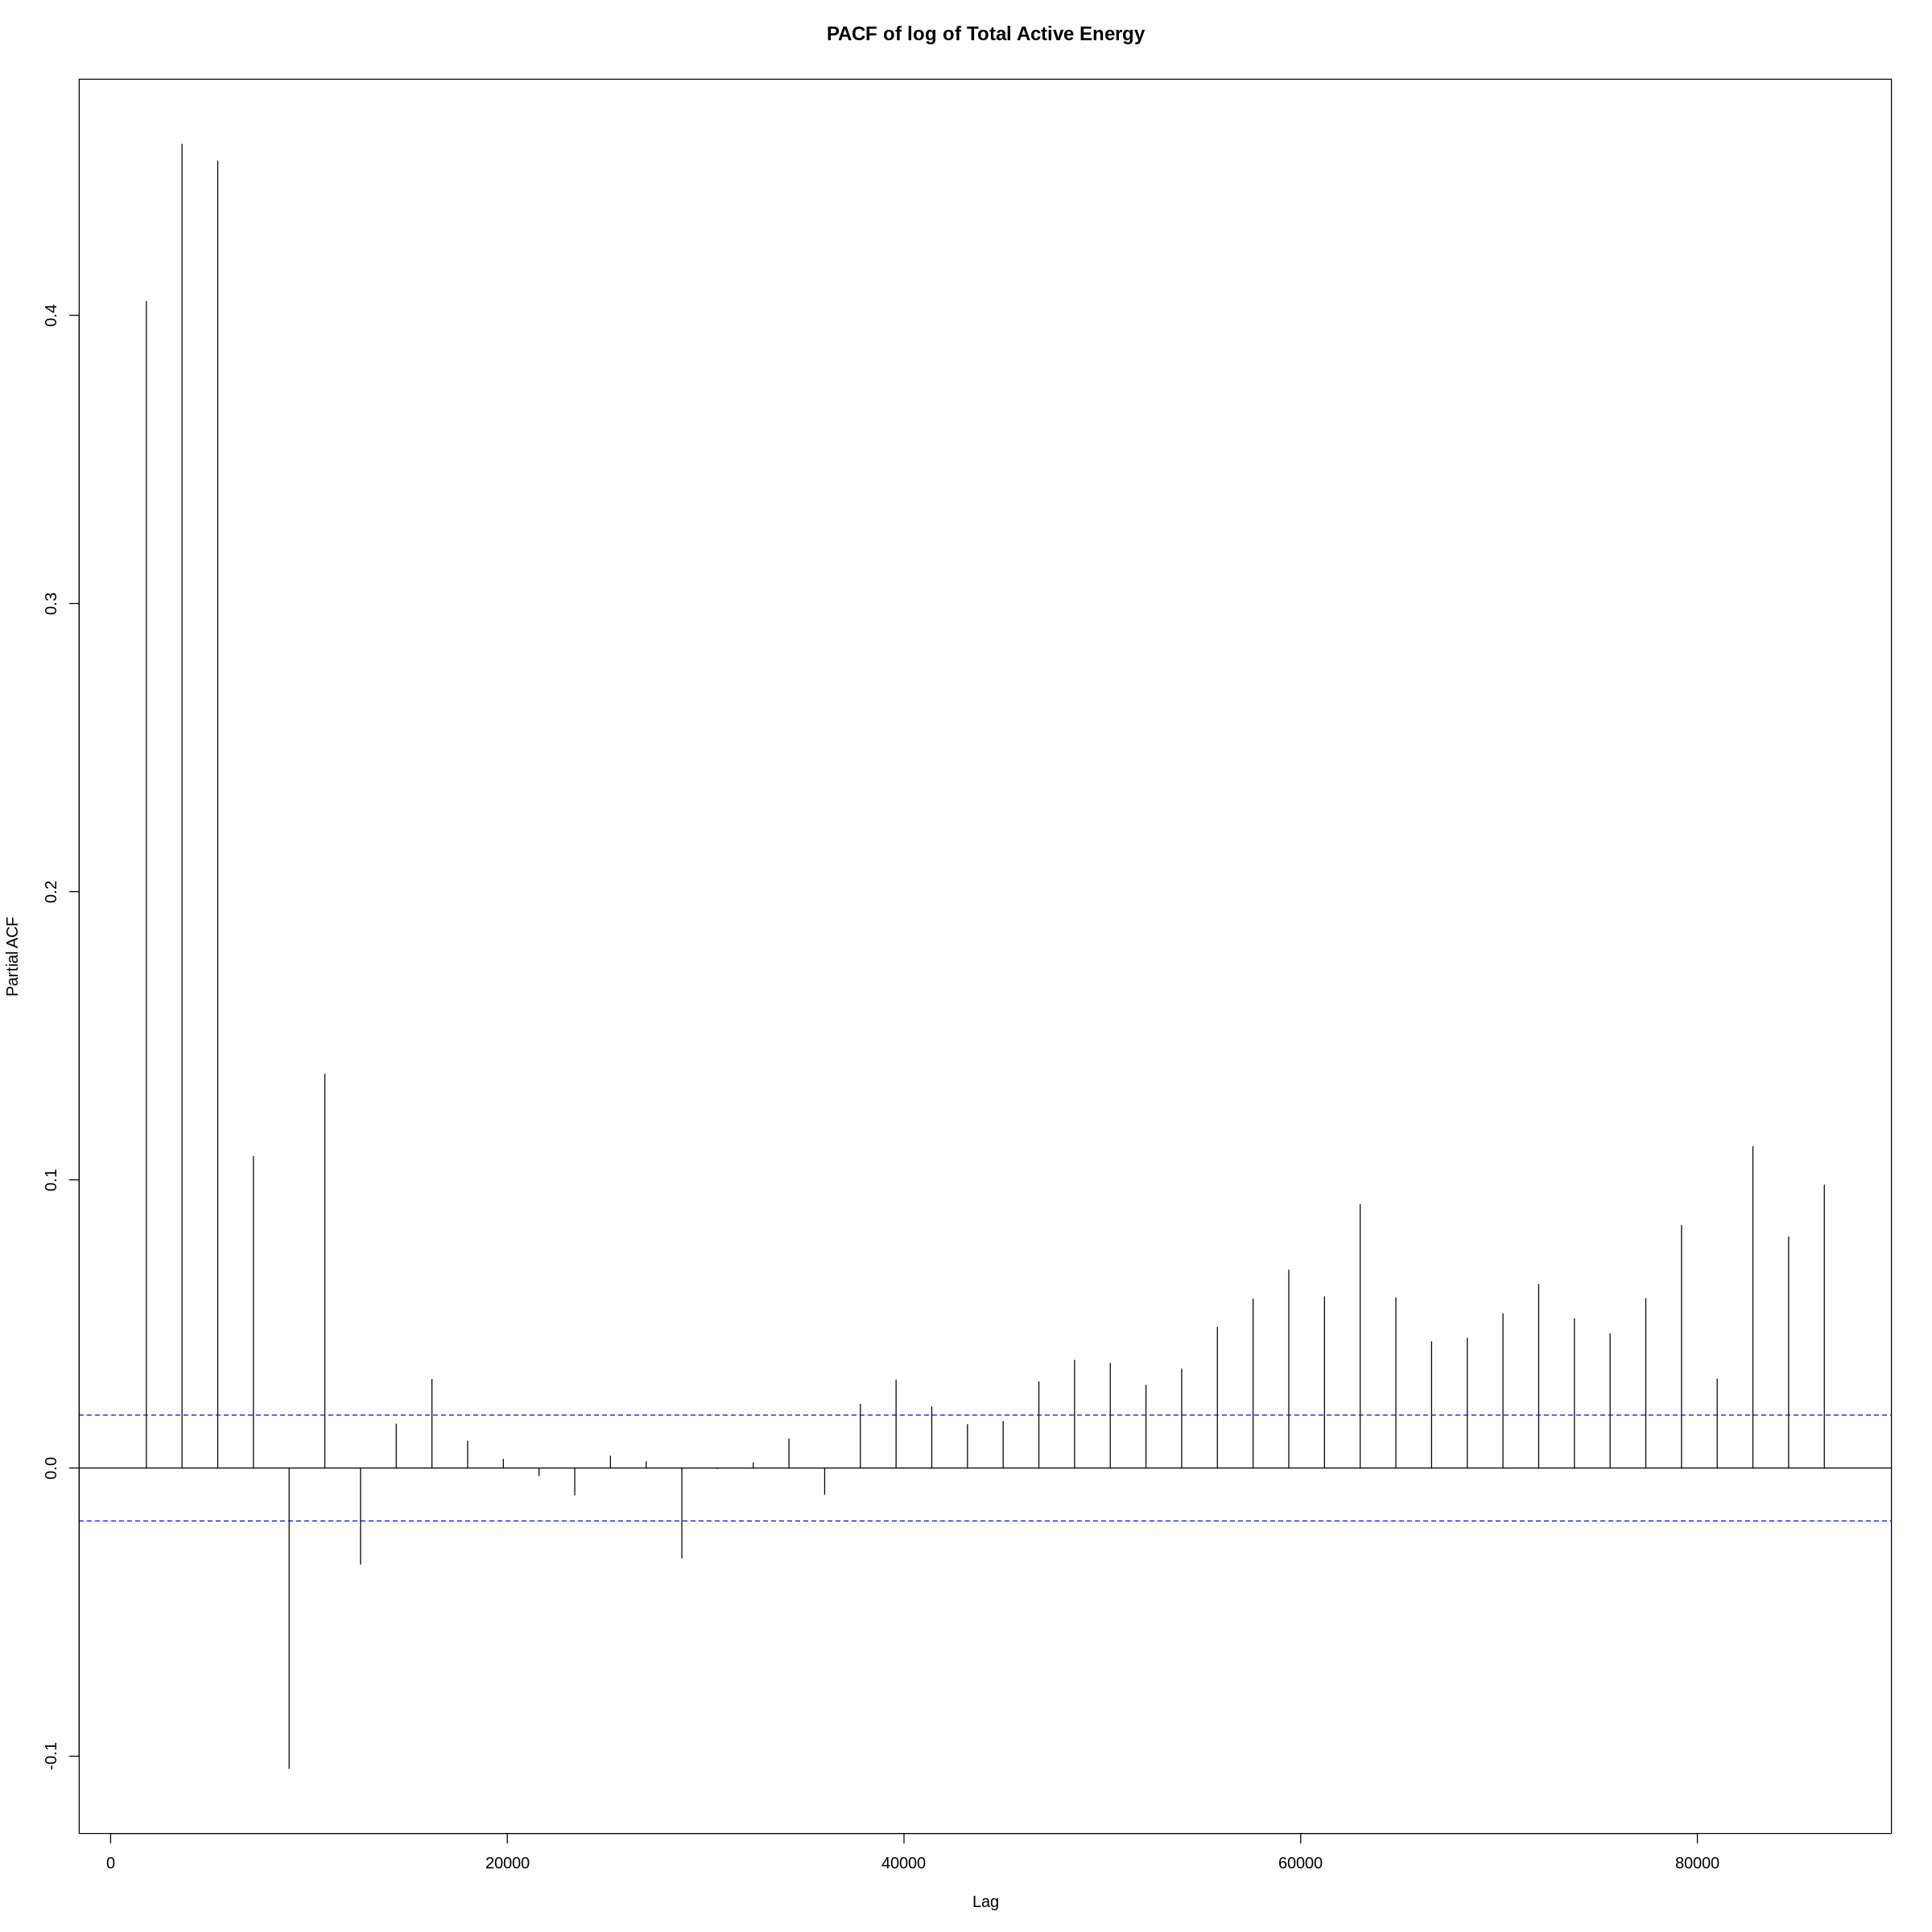

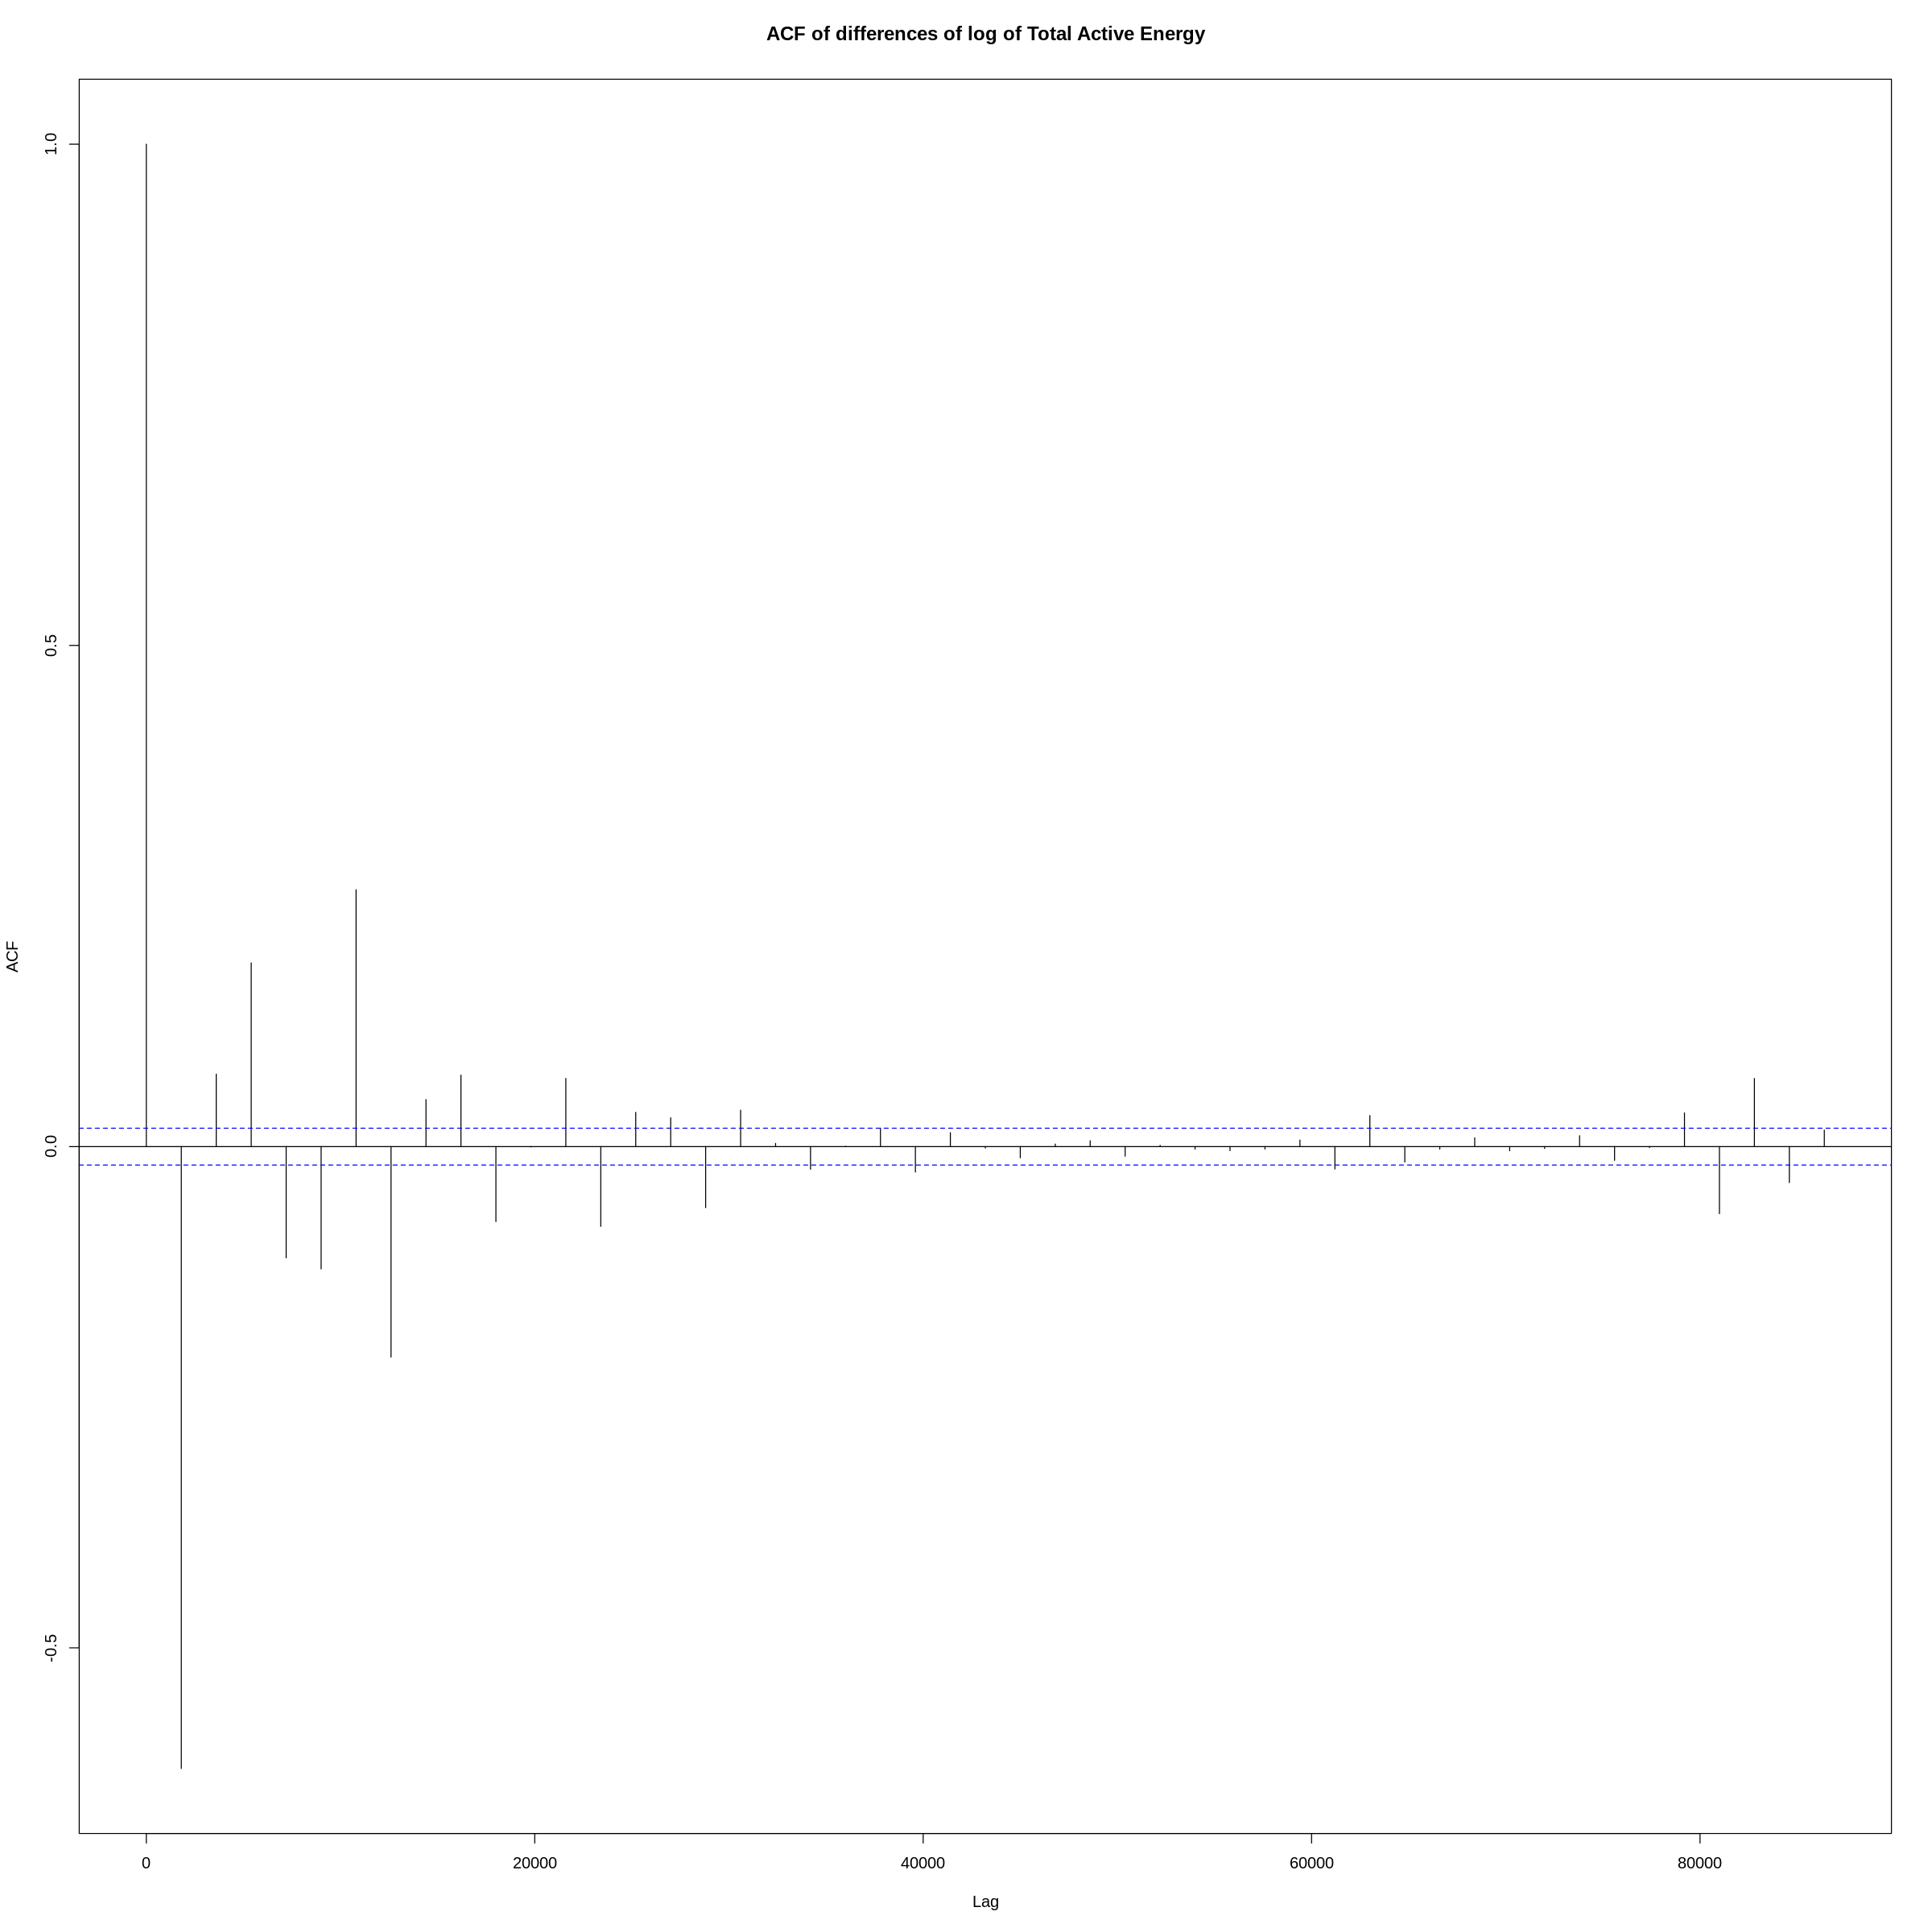

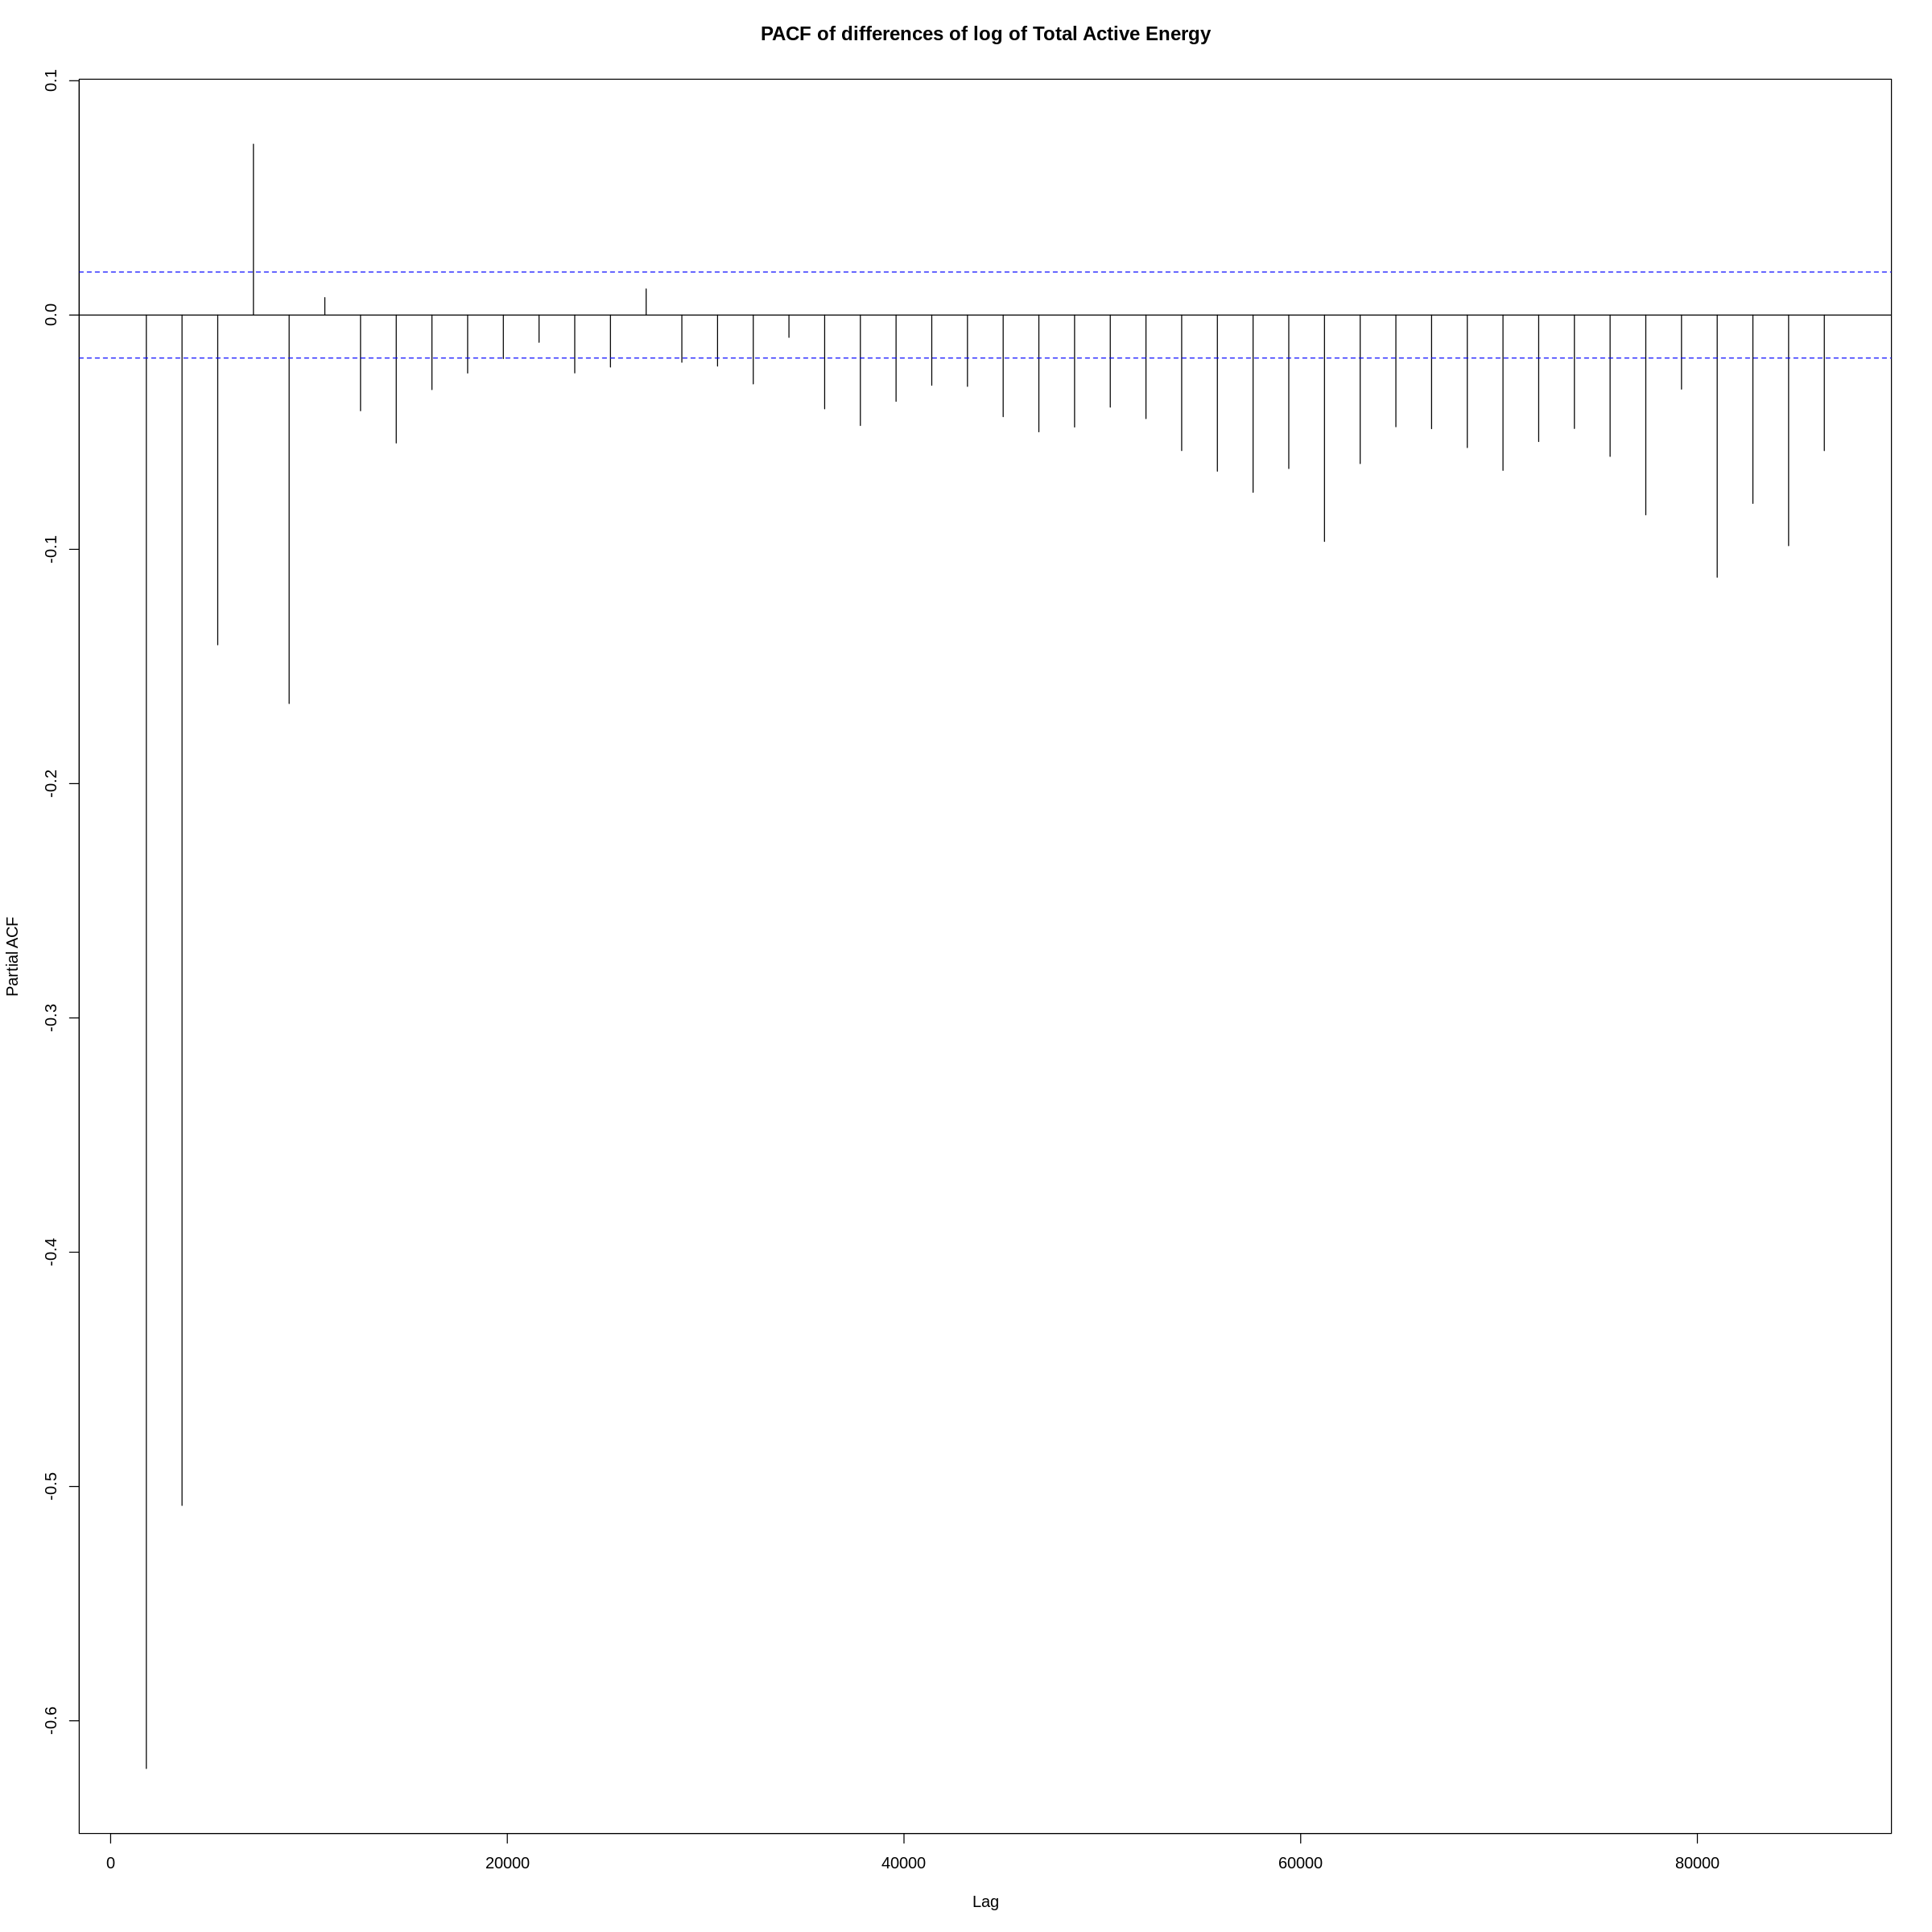

In [23]:
acf(j, 48, main="ACF of Total Active Energy") # autocorrelation function plot
pacf(j, 48, main="PACF of Total Active Energy") # partial autocorrelation function
acf(lj, 48, main="ACF of log of Total Active Energy")
pacf(lj, 48, main="PACF of log of Total Active Energy")
acf(dlj, 48, main="ACF of differences of log of Total Active Energy", na.action = na.pass)
pacf(dlj, 48, main="PACF of differences of log of Total Active Energy", na.action = na.pass)

The null hypothesis of non-stationarity is rejected for all cases with respect to trend.

## Normality tests


	Shapiro-Wilk normality test

data:  sample(coredata(j), 5000, replace = FALSE)
W = 0.97655, p-value < 2.2e-16


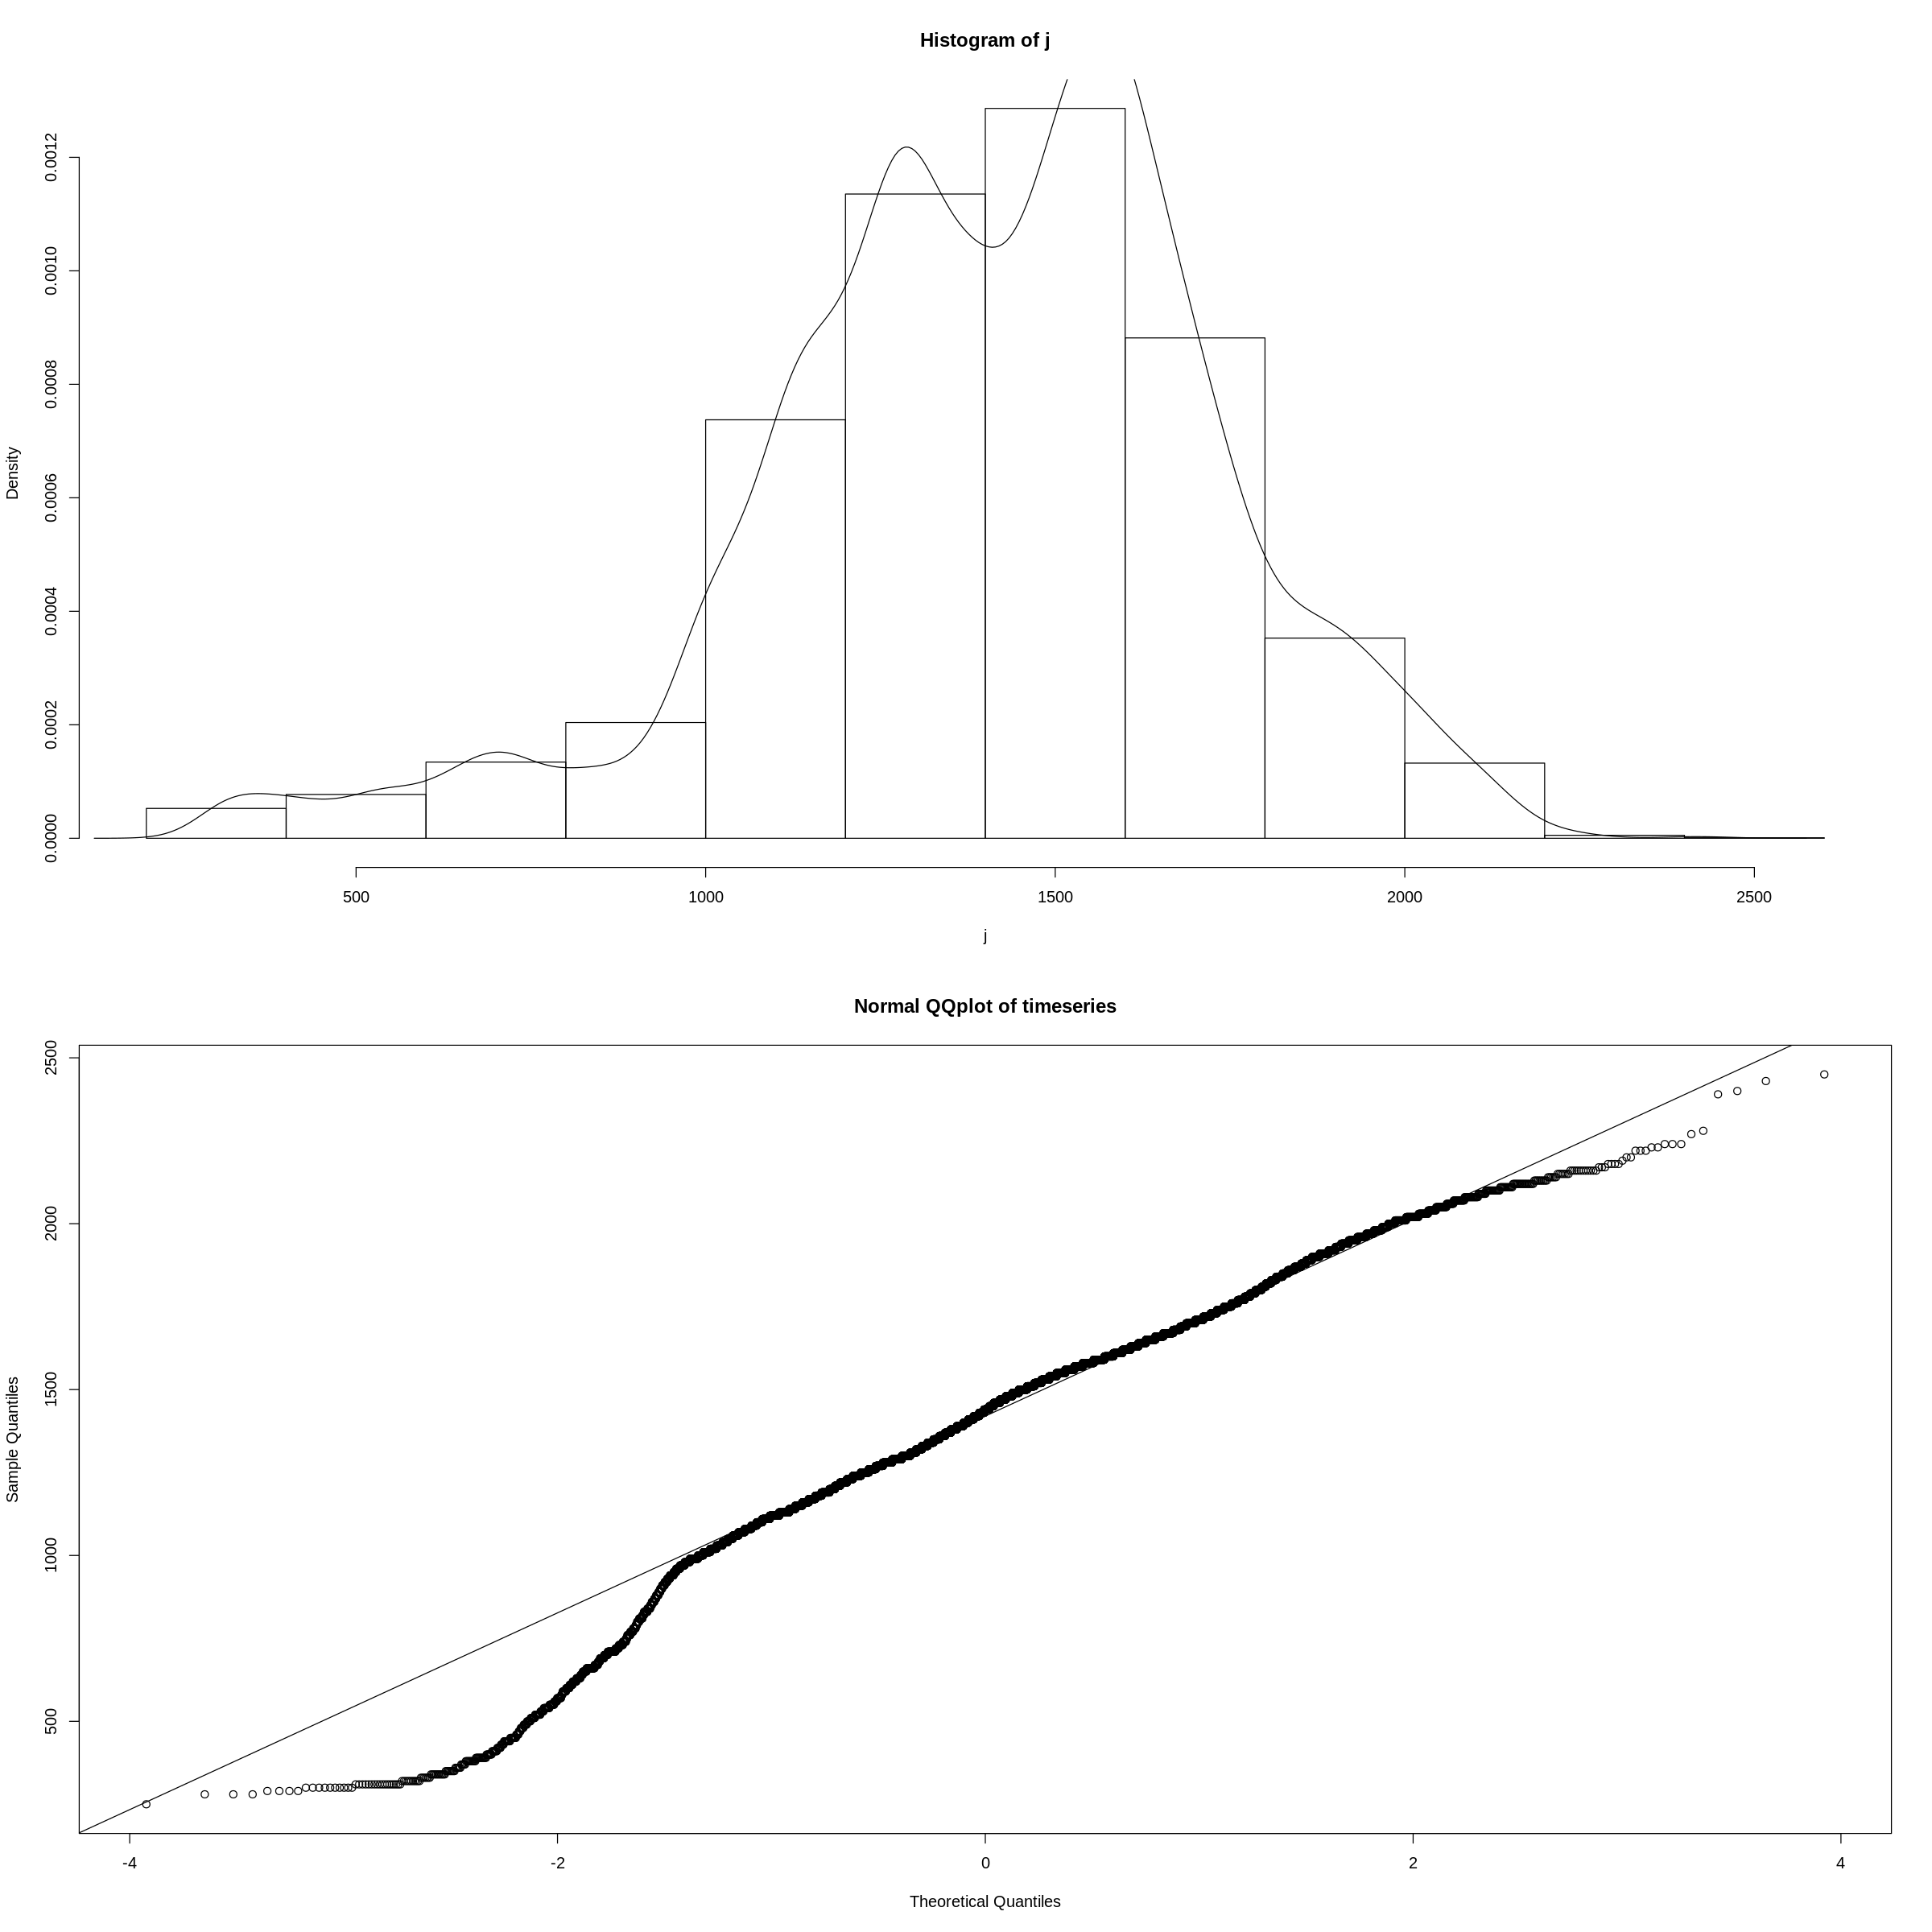

In [24]:
shapiro.test(sample(coredata(j), 5000, replace=FALSE))

par(mfrow=c(2,1))
hist(j, prob=TRUE, 15) # histogram
lines(density(j)) # smooth it - ?density for details
qqnorm(j,main="Normal QQplot of timeseries") # normal Q-Q plot
qqline(j)


	Shapiro-Wilk normality test

data:  sample(coredata(lj), 5000, replace = FALSE)
W = 0.85762, p-value < 2.2e-16


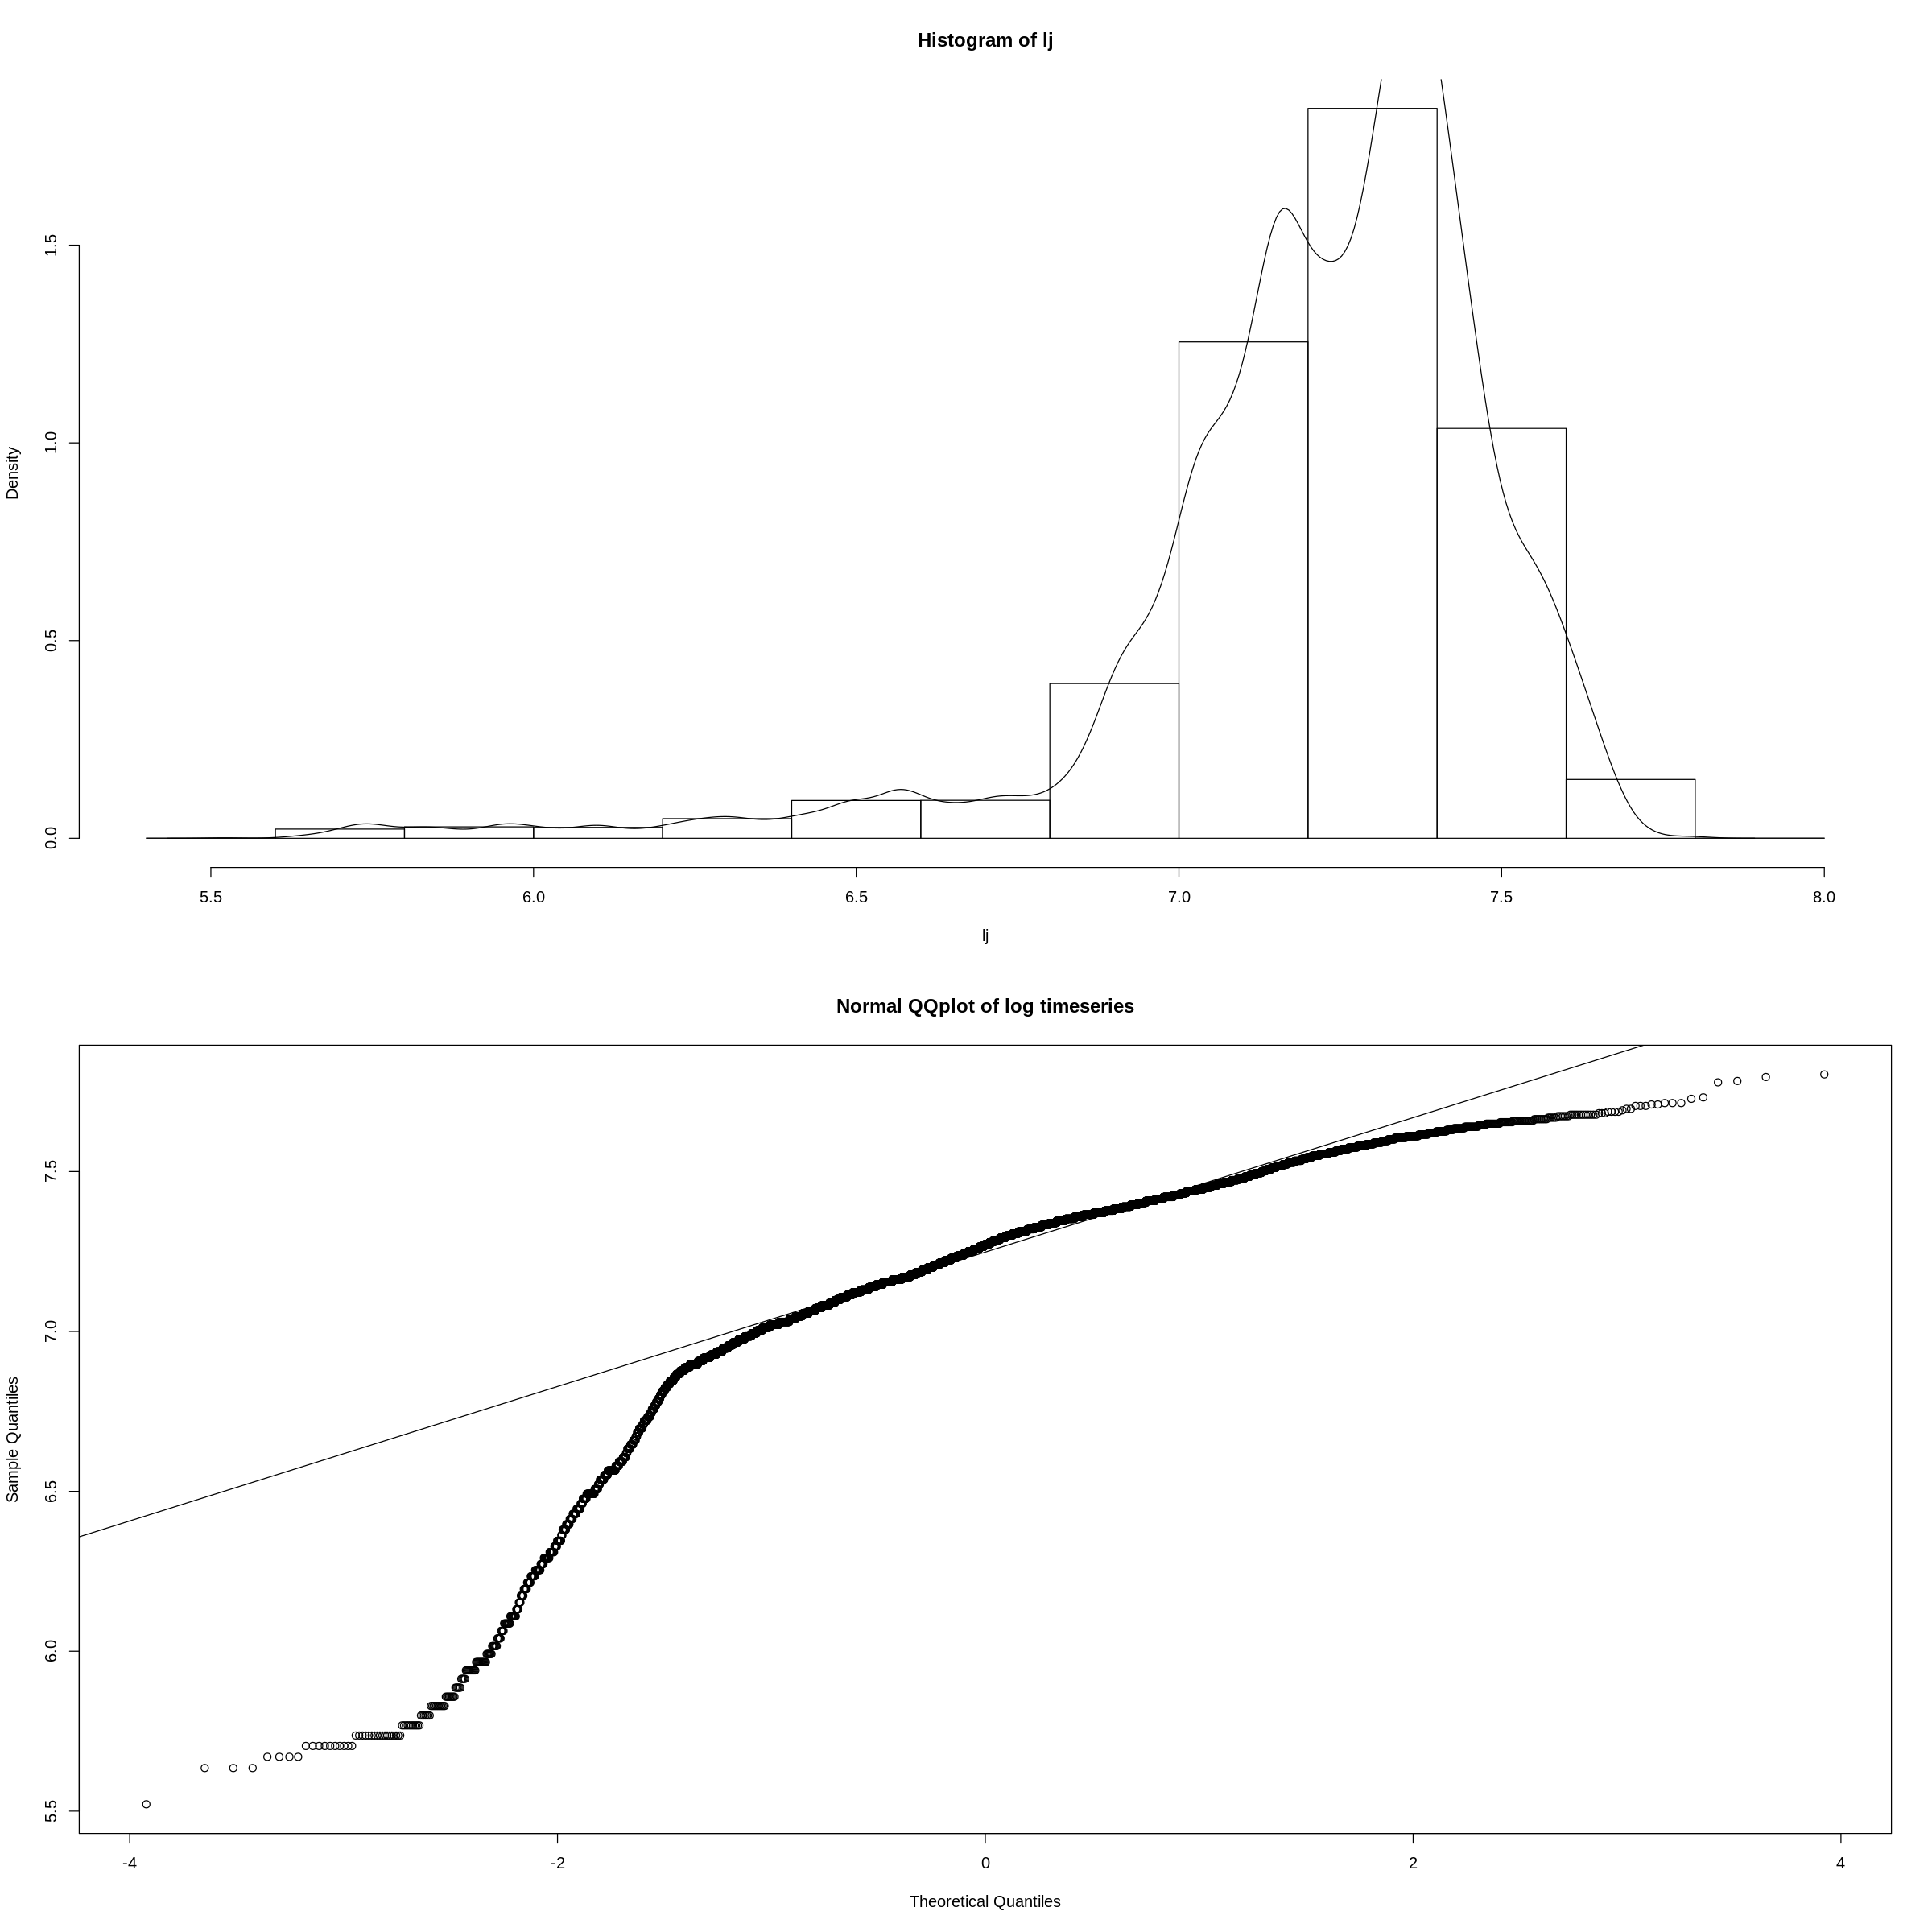

In [25]:
shapiro.test(sample(coredata(lj), 5000, replace=FALSE))

par(mfrow=c(2,1))
hist(lj, prob=TRUE, 15) # histogram
lines(density(lj)) # smooth it - ?density for details
qqnorm(lj,main="Normal QQplot of log timeseries") # normal Q-Q plot
qqline(lj)


	Shapiro-Wilk normality test

data:  sample(coredata(dlj), 5000, replace = FALSE)
W = 0.91625, p-value < 2.2e-16


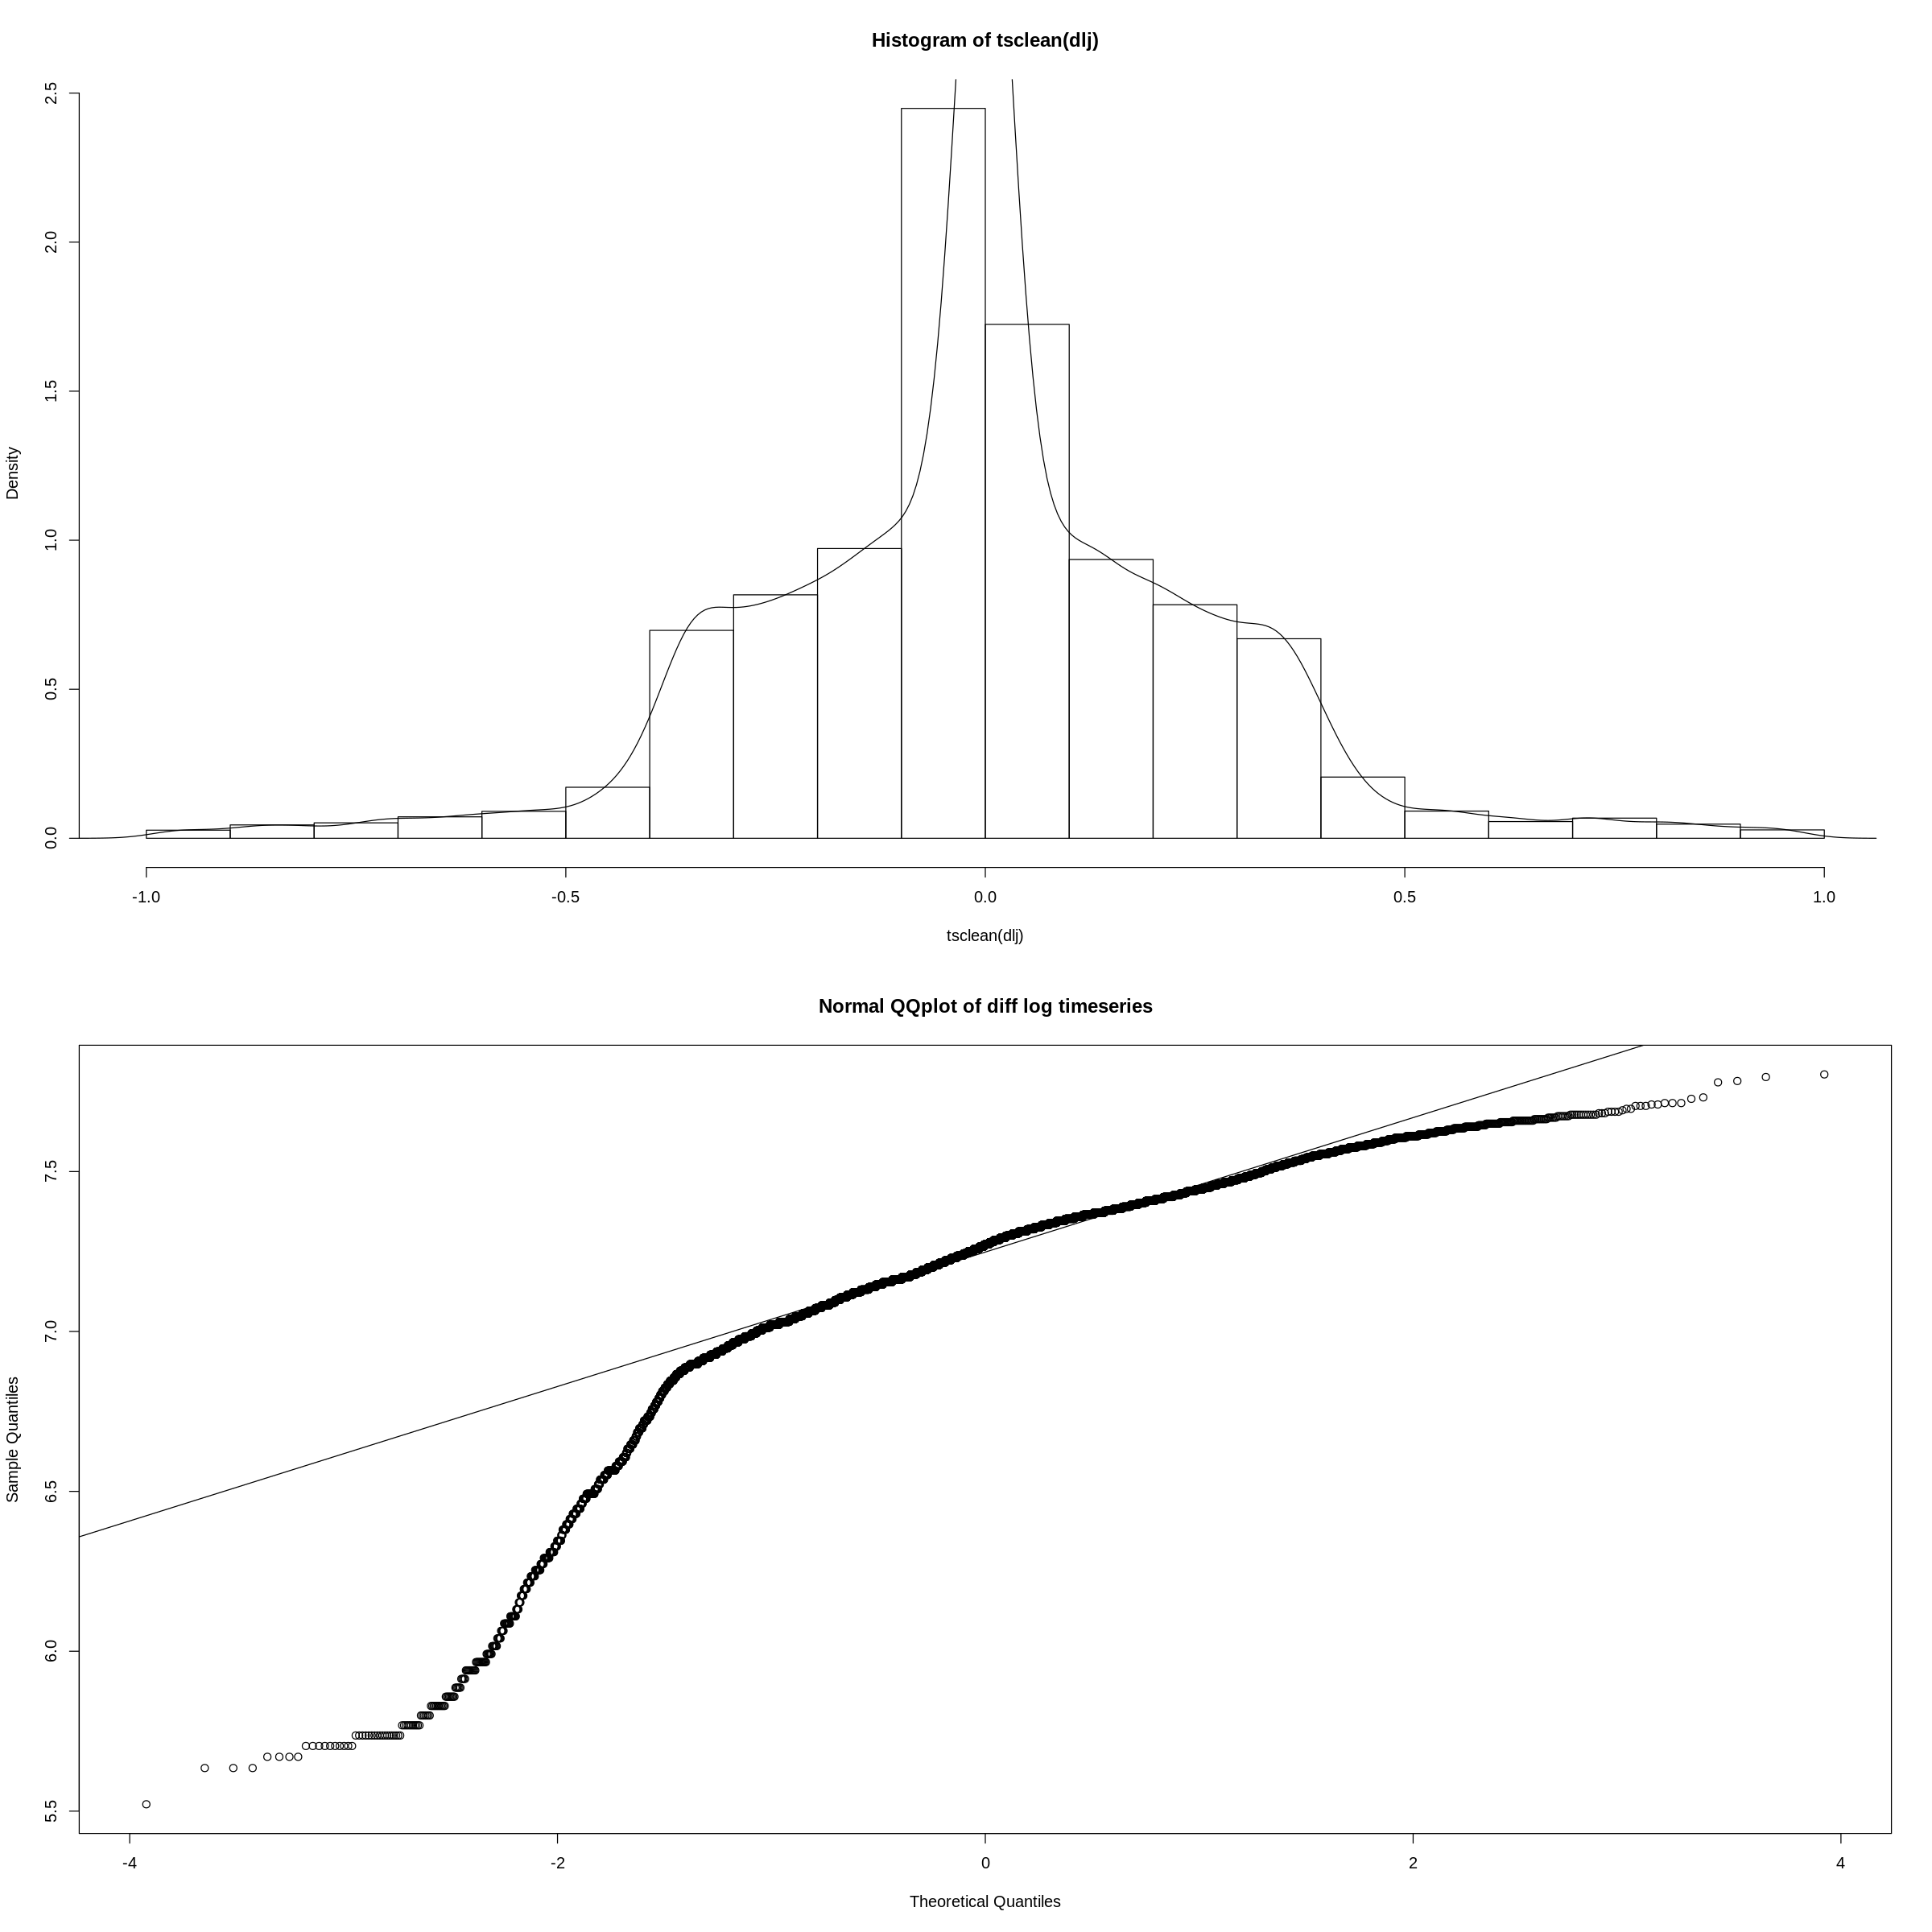

In [26]:
shapiro.test(sample(coredata(dlj), 5000, replace=FALSE))

par(mfrow=c(2,1))
hist(tsclean(dlj), prob=TRUE, 15) # histogram
lines(density(tsclean(dlj))) # smooth it - ?density for details
qqnorm(lj,main="Normal QQplot of diff log timeseries") # normal Q-Q plot
qqline(lj)

Null hypothesis for normality is rejected in all cases according to the Shapiro tests and qqplots. So we will need to consider the BoxCox transformation in the training process.

### Box Cox transform
A sample Box Cox transformation


	Shapiro-Wilk normality test

data:  sample(coredata(normalised), 5000, replace = FALSE)
W = 0.99122, p-value < 2.2e-16


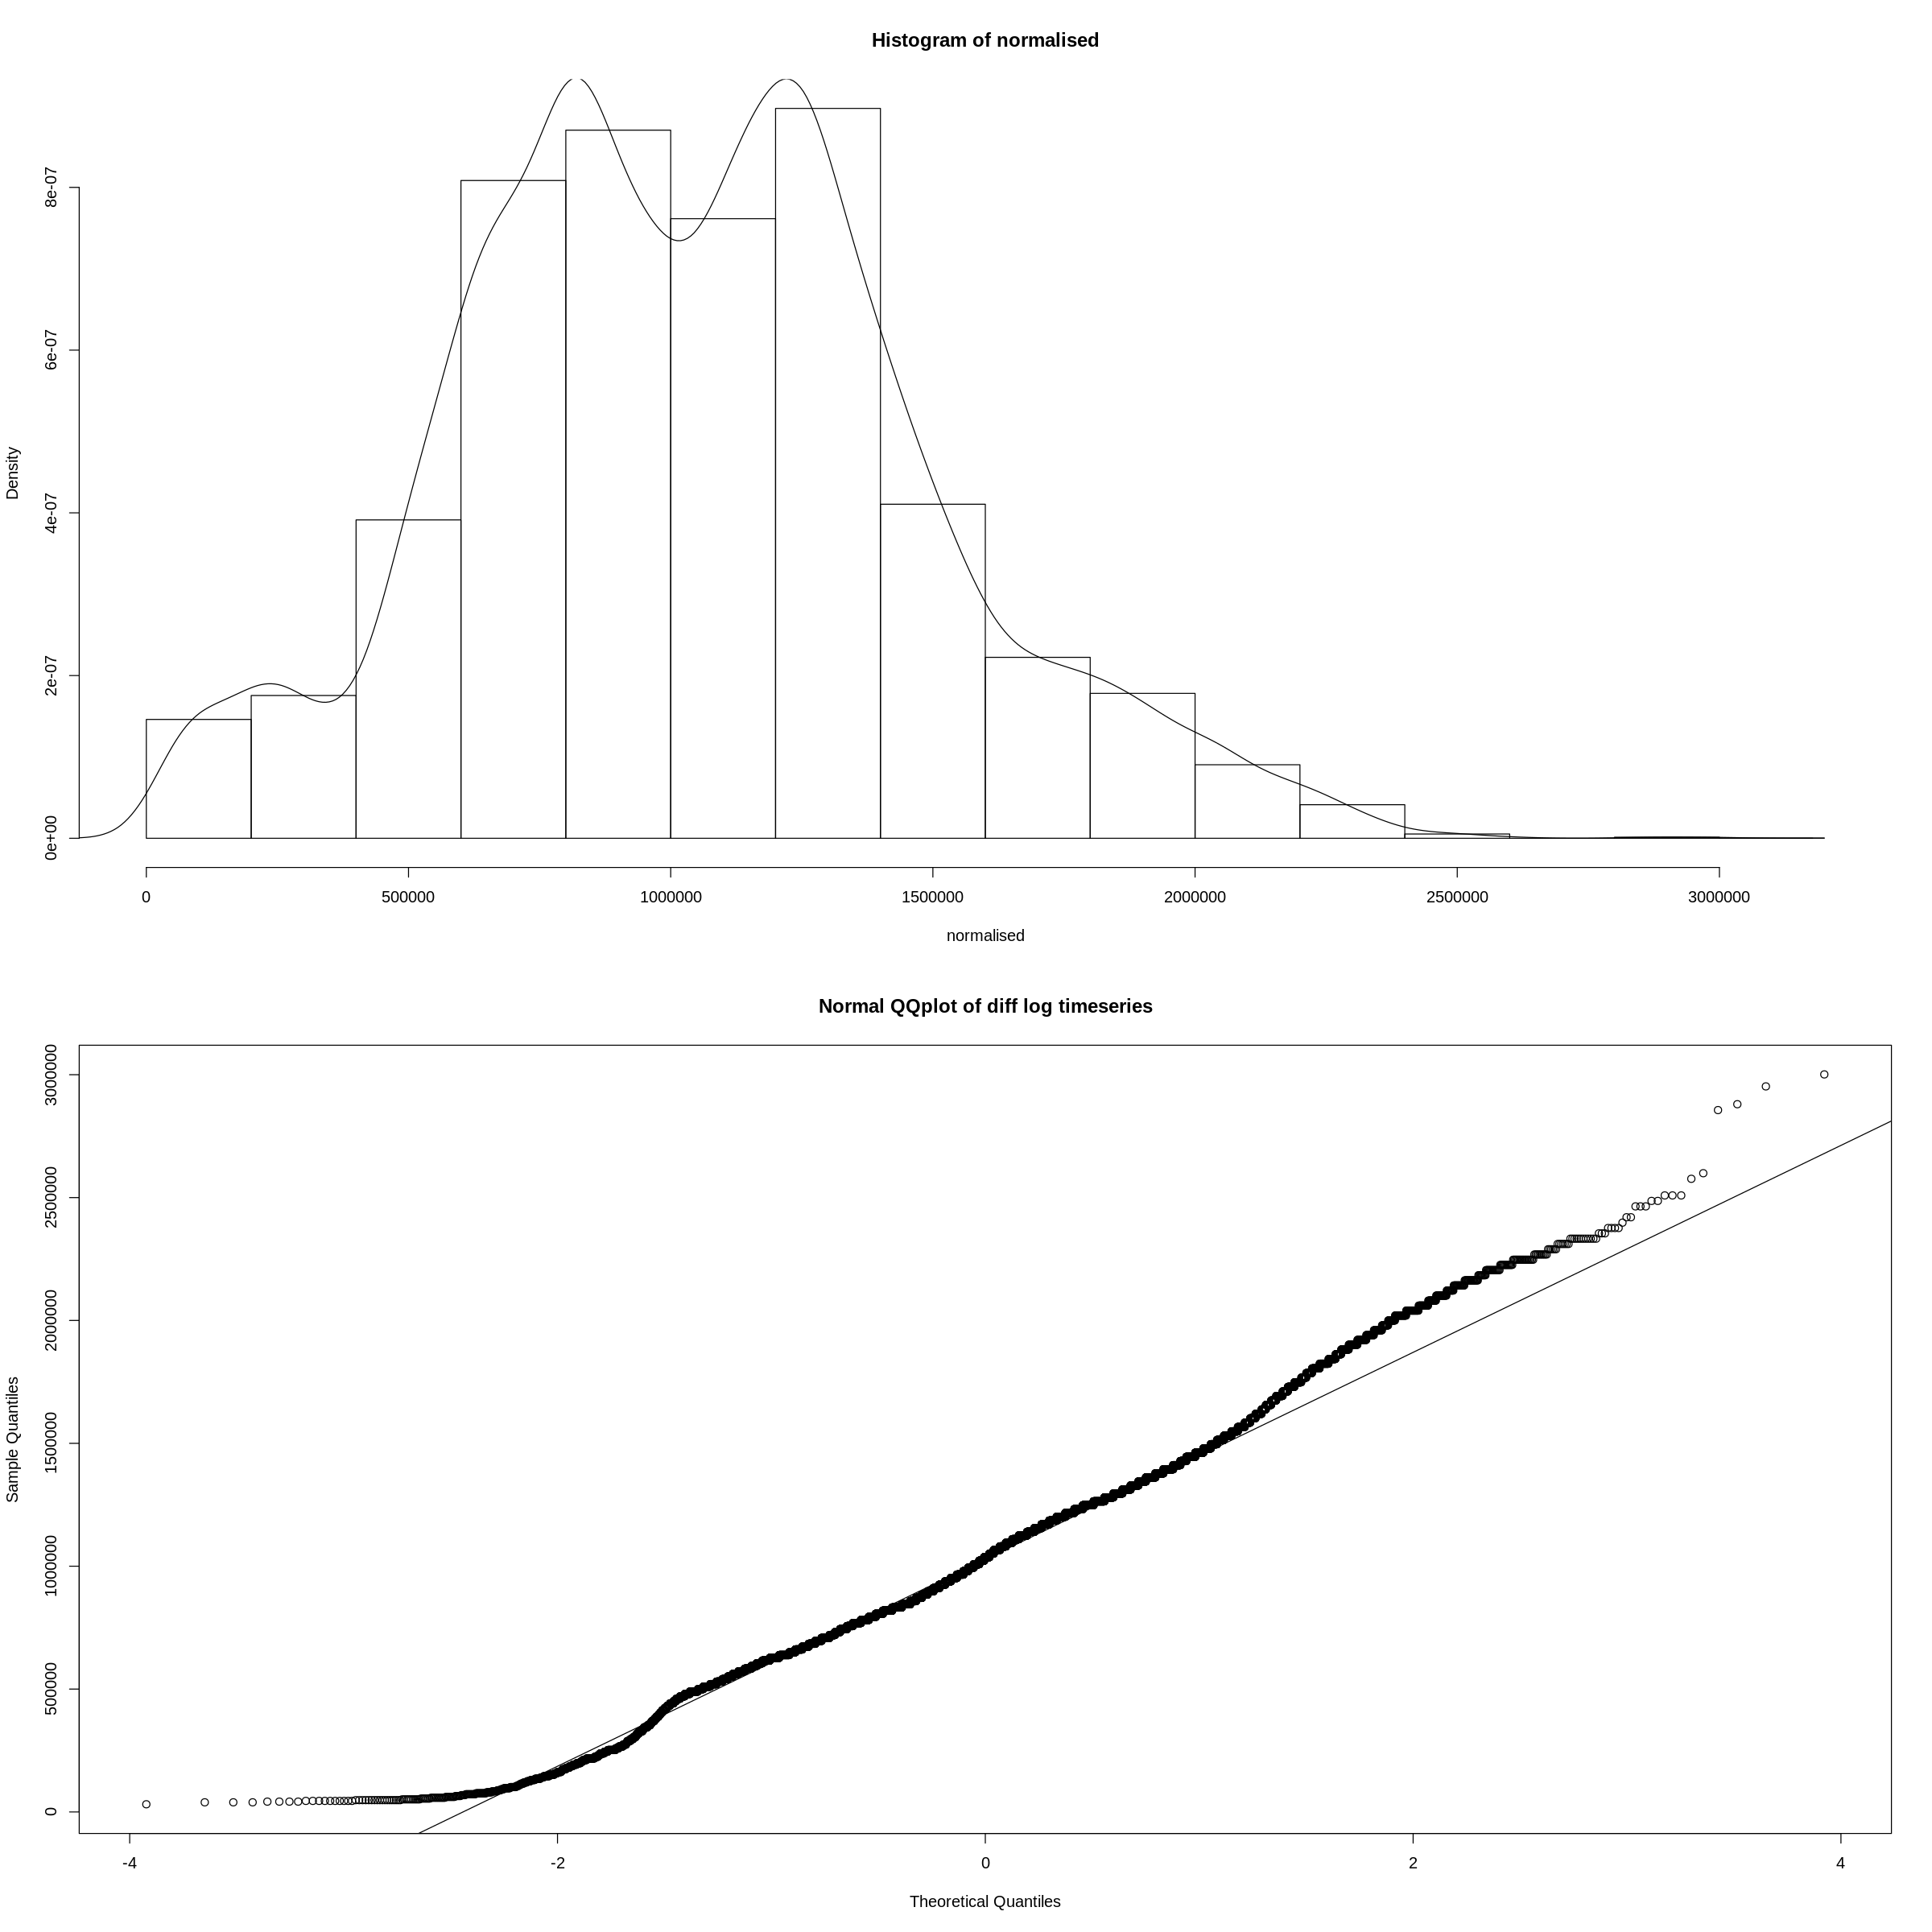

In [66]:
normalised=BoxCox(j, 2)
shapiro.test(sample(coredata(normalised), 5000, replace=FALSE))
par(mfrow=c(2,1))
hist(normalised, prob=TRUE, 15) # histogram
lines(density(tsclean(normalised))) # smooth it - ?density for details
qqnorm(normalised,main="Normal QQplot of diff log timeseries") # normal Q-Q plot
qqline(normalised)

In [82]:
ltrain = lj['/2021-06-15 23:30:00']
ltest = lj['2021-06-16 00:00:00/']

In [83]:
### auto.arima

In [84]:
auto <- auto.arima(tsclean(ltrain), stepwise=FALSE, approximation=FALSE, num.cores=6, lambda='auto', biasadj=TRUE)

In [85]:
summary(auto)

Series: tsclean(ltrain) 
ARIMA(3,1,1) 
Box Cox transformation: lambda= 1.999927 

Coefficients:
         ar1     ar2     ar3      ma1
      0.0750  0.4710  0.1387  -0.9894
s.e.  0.0097  0.0087  0.0097   0.0015

sigma^2 estimated as 1.35:  log likelihood=-16749.35
AIC=33508.69   AICc=33508.7   BIC=33545.07

Training set error measures:
                       ME      RMSE       MAE         MPE     MAPE       MASE
Training set -0.001492005 0.1646154 0.1166002 -0.07424605 1.636751 0.01608706
                  ACF1
Training set -0.013778

In [86]:
### tbats

Seasonal periods: 48 (daily), 336 (weekly). (1 day = 48 * 30 min timesteps)

In [87]:
tb <- tbats(tsclean(ltrain), use.box.cox = TRUE, use.trend = TRUE, use.damped.trend=TRUE, 
               seasonal.periods=c(24, 168), use.arma.errors=TRUE, 
               use.parallel=TRUE, num.cores=6, biasadj=TRUE)
tb

TBATS(1, {5,4}, 0.991, {<48,8>, <336,6>})

Call: tbats(y = tsclean(ltrain), use.box.cox = TRUE, use.trend = TRUE, 
    use.damped.trend = TRUE, seasonal.periods = c(48, 336), use.arma.errors = TRUE, 
    use.parallel = TRUE, num.cores = 6, biasadj = TRUE)

Parameters
  Lambda: 1
  Alpha: 0.2229734
  Beta: -0.002194465
  Damping Parameter: 0.990972
  Gamma-1 Values: 7.230775e-05 0.0007894309
  Gamma-2 Values: 8.724276e-05 -3.437389e-05
  AR coefficients: -0.133469 0.307396 0.120498 -0.049532 -0.11325
  MA coefficients: -0.051259 -0.095401 -0.047353 0.090672

Seed States:
               [,1]
 [1,]  6.6650081338
 [2,] -0.0036400737
 [3,]  0.0291392999
 [4,] -0.0312363518
 [5,]  0.0098267507
 [6,] -0.0108755994
 [7,] -0.0138389146
 [8,] -0.0015928312
 [9,] -0.0162441330
[10,] -0.0051893949
[11,]  0.0829356849
[12,]  0.0111955093
[13,]  0.0130683419
[14,]  0.0219092710
[15,] -0.0059353330
[16,]  0.0022451484
[17,]  0.0036042596
[18,] -0.0087183841
[19,] -0.0110562695
[20,] -0.0002944588
[21

In [90]:
forecast <- predict(tb, 24)

# plot of forecasts with 1 standard error
par(mfrow=c(1,1))
UL <- forecast$meanForecast + forecast$meanError
LL <- forecast$meanForecast - forecast$meanError

predTS <- ts(forecast$meanForecast, frequency=120, start = c(2021, 06, 15, 23, 30, 00))
UL_TS <- ts(forecast$meanForecast, frequency=120, start = c(2021, 06, 15, 23, 30, 00))
LL_TS <- ts(forecast$meanForecast, frequency=120, start = c(2021, 06, 15, 23, 30, 00))

# min_x <- min(stepSRresidualsTS, LL)
# max_x <- max(stepSRresidualsTS, UL)

# ts.plot(stepSRresidualsTS, predTS)
lines(predTS, col="red", type="o")
lines(UL_TS, col="blue", lty="dashed")
lines(LL_TS, col="blue", lty="dashed")

ERROR: Error in try.xts(0): Error in as.xts.double(x, ..., .RECLASS = TRUE) :   order.by must be either 'names()' or otherwise specified
